In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth

In [2]:
data = pd.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv')
data.columns = [x.strip() for x in data.columns.tolist()]
X = data.drop(columns = ['weekday_is_monday',
 'weekday_is_saturday',
 'LDA_00',
 'n_unique_tokens',
 'n_non_stop_words',
 'self_reference_avg_sharess',
 'rate_positive_words',
 'LDA_04',
 'LDA_02',
 'kw_max_max',
 'kw_avg_min',
 'kw_avg_avg',
 'rate_negative_words',
 'min_negative_polarity', 'url', 'timedelta', 'shares'])
y = data['shares']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45)

# We will start tuning parameters one by one to look for a general range to look for, for when we tune all the parameters at the same time

### Number of trees
We will use the same number of trees - 100 for all future fitting, until the final model, because we will be using the early_stopping_rounds of the XGBRegressor to determine the right number of trees.

### Depth of the model

>1 2410.643 (229.324)
>2 2403.561 (231.199)
>3 2404.479 (232.812)
>4 2414.343 (232.710)
>5 2433.291 (233.620)
>6 2447.415 (226.553)
>7 2469.566 (235.096)
>8 2489.745 (232.133)
>9 2505.990 (227.905)
>10 2510.741 (236.067)
>11 2517.086 (230.617)
>12 2518.309 (230.329)
>13 2530.547 (227.740)
>14 2532.195 (227.782)
>15 2528.349 (223.834)
>16 2533.048 (223.466)
>17 2536.756 (229.450)
>18 2532.867 (231.111)
>19 2527.820 (226.332)
>20 2528.956 (222.060)


Text(0.5, 0, 'Depth of each tree')

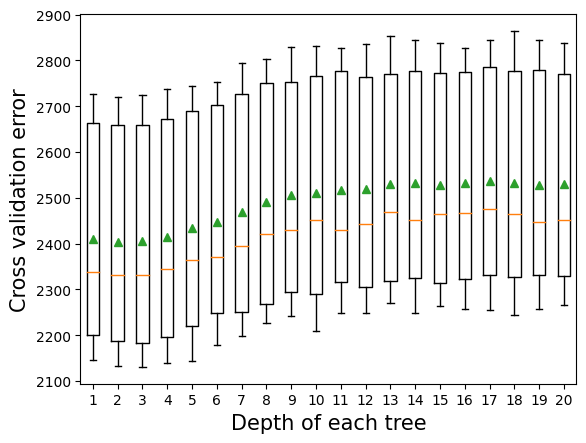

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define ensemble model
        models[str(i)] = xgb.XGBRegressor(random_state=1,max_depth=i)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(TransformedTargetRegressor(model, func = np.log, inverse_func = np.exp), X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

### Learning rate

>0.0100 3278.7 (230.8)
>0.0500 2384.8 (232.9)
>0.1000 2398.3 (232.7)
>0.2000 2418.4 (232.6)
>0.3000 2447.4 (226.6)
>0.4000 2496.7 (231.1)
>0.5000 2558.3 (245.8)
>0.6000 2611.6 (235.0)
>0.8000 2778.3 (234.6)
>1.0000 3088.1 (368.1)


Text(0.5, 0, 'Learning rate')

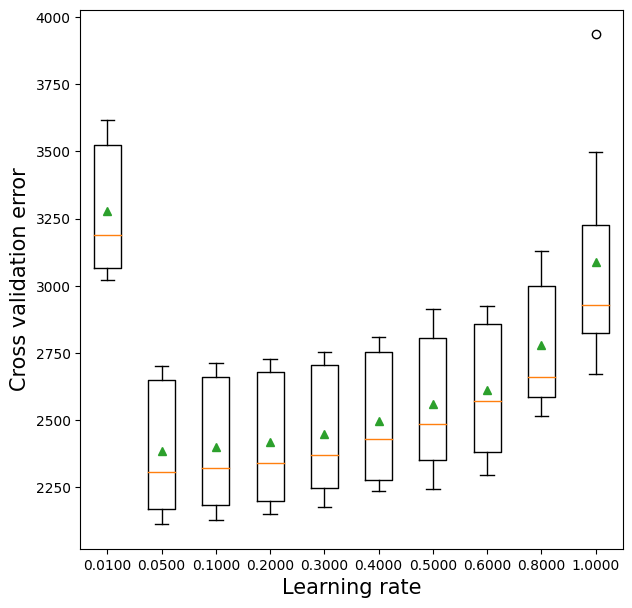

In [ ]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(TransformedTargetRegressor(model, func = np.log, inverse_func = np.exp), X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

### Regularization

>0.0000 2478.5 (236.6)
>10.0000 2431.6 (235.5)
>100.0000 2416.1 (233.4)
>1000.0000 2397.8 (232.8)
>10000.0000 2397.5 (232.0)
>100000.0000 2436.6 (228.3)
>1000000.0000 3331.9 (231.0)
>10000000.0000 3414.4 (230.9)
>100000000.0000 3415.5 (230.9)


Text(0.5, 0, 'reg_lambda')

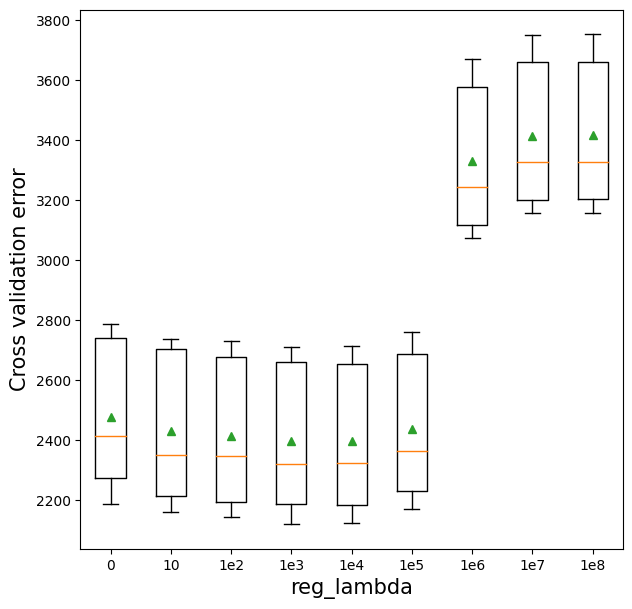

In [ ]:
# Fine tune more general range for regularization
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(TransformedTargetRegressor(model, func = np.log, inverse_func = np.exp), X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=['0', '10', '1e2', '1e3', '1e4', '1e5', '1e6', '1e7', '1e8'], showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)


Regularization alpha

>0.0000 2447.4 (226.6)
>10.0000 2426.5 (236.9)
>100.0000 2397.7 (232.3)
>1000.0000 2435.3 (228.1)
>10000.0000 2494.0 (230.6)
>100000.0000 3364.5 (231.0)
>1000000.0000 3415.6 (230.9)
>10000000.0000 3415.6 (230.9)
>100000000.0000 3415.6 (230.9)


Text(0.5, 0, 'reg_alpha')

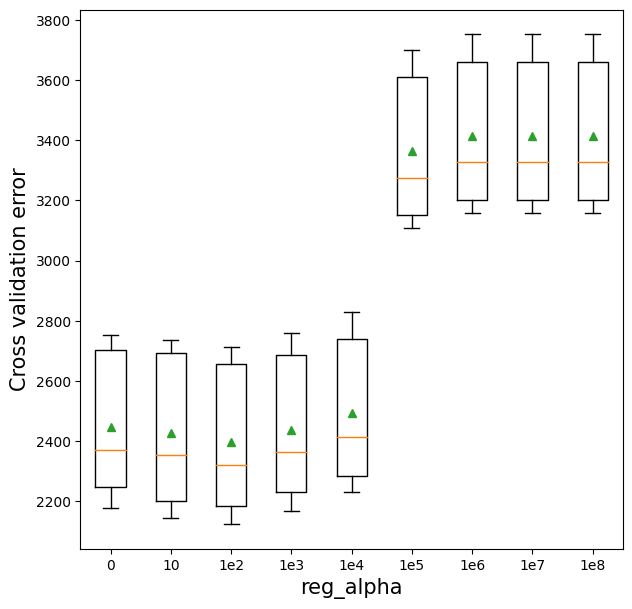

In [ ]:
# Fine tune more general range for regularization
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_alpha=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(TransformedTargetRegressor(model, func = np.log, inverse_func = np.exp), X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=['0', '10', '1e2', '1e3', '1e4', '1e5', '1e6', '1e7', '1e8'], showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_alpha',fontsize=15)

### Regularization in gamma

>0.0000 2447.4 (226.6)
>10.0000 2406.6 (233.7)
>100.0000 2434.8 (226.7)
>1000.0000 2498.7 (228.5)
>10000.0000 2513.6 (228.4)
>100000.0000 2513.6 (228.4)
>1000000.0000 2513.6 (228.4)
>10000000.0000 2513.6 (228.4)
>100000000.0000 2513.6 (228.4)
>1000000000.0000 2513.6 (228.4)


Text(0.5, 0, 'gamma')

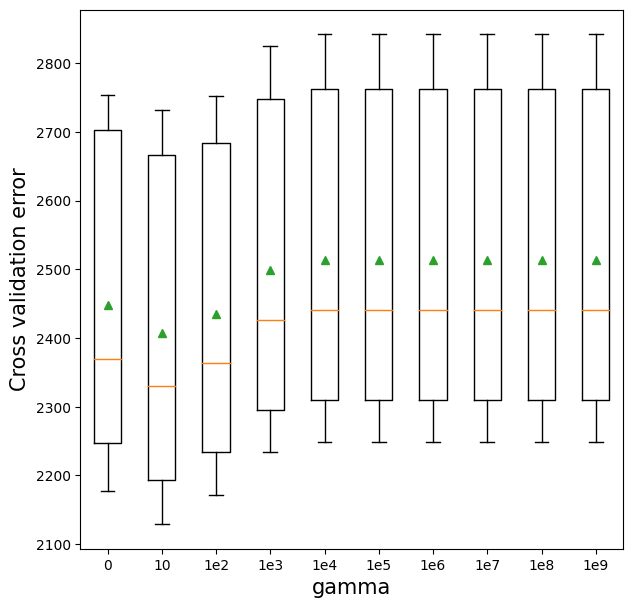

In [ ]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(gamma=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = -cross_val_score(TransformedTargetRegressor(model, func = np.log, inverse_func = np.exp), X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=['0', '10', '1e2', '1e3', '1e4', '1e5', '1e6', '1e7', '1e8', '1e9'], showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

### Tuning full model with everything

In [ ]:
y_train = y_train.apply(lambda x: y_train.mean() if np.isnan(x) else x)

In [ ]:
#K-fold cross validation to find optimal parameters for XGBoost
# Coarse search
start_time = time.time()
param_grid = {'regressor__max_depth': [2, 4, 6, 8, 10],
              'regressor__learning_rate': [0.01, 0.1, 0.5, 1.0, 2.0],
              'regressor__reg_alpha':[0, 5, 10, 100, 500],
               'regressor__reg_lambda':[0, 5, 10, 100, 500],
                'regressor__n_estimators':[1000, 3000, 5000],
                'regressor__gamma': [0, 2, 4, 6, 8, 11, 14, 17],
                'regressor__subsample': [0.3, 0.4, 0.6, 0.75, 1],
                'regressor__colsample_bytree': [0.5, 0.75, 1]}

estimator = TransformedTargetRegressor(xgb.XGBRegressor(random_state=1), func = np.log, inverse_func = np.exp)

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=estimator,                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1, scoring = 'neg_mean_absolute_error',
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train, y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation MAE = ",-optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [-2.31265935e+03 -2.37665905e+03 -2.34899420e+03 -2.32885755e+03
 -2.35725306e+03 -3.48558027e+03 -2.37857691e+03 -2.37888727e+03
 -2.62636761e+03 -2.32692330e+03 -2.35025575e+03 -2.34991048e+03
 -2.33222756e+03 -2.35752937e+03 -2.31985839e+03 -2.74454420e+03
 -2.51992723e+03 -3.95206705e+04 -2.32509405e+03 -2.34049672e+03
 -2.60165296e+03 -2.35026964e+03 -2.45131550e+03 -2.35887239e+03
 -2.37507878e+03 -2.33490413e+03             nan -2.48384781e+03
 -2.31350960e+03 -2.37399865e+03 -2.78434543e+03 -2.32353129e+03
 -2.31339342e+03 -2.37835577e+03 -2.38018335e+03 -2.32820795e+03
 -2.32579821e+03           

Optimal parameter values = {'regressor__subsample': 0.6, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 5, 'regressor__n_estimators': 1000, 'regressor__max_depth': 4, 'regressor__learning_rate': 0.01, 'regressor__gamma': 6, 'regressor__colsample_bytree': 0.75}
Optimal cross validation MAE =  2309.3118685193926
Time taken =  58  minutes


In [3]:
xgb_model = xgb.XGBRegressor(random_state = 1, max_depth = 4, learning_rate = 0.01,
                        n_estimators = 1000,reg_lambda = 0, reg_alpha = 5, gamma = 6, subsample = 0.6, 
                         colsample_bytree = 0.75, eval_metric = mean_absolute_error)
xgb_model = TransformedTargetRegressor(xgb_model, func = np.log, inverse_func = np.exp).fit(X_train, y_train)
print('XGBoost MAE is {}'.format(mean_absolute_error(y_train, xgb_model.predict(X_train))))

XGBoost MAE is 2362.9755480462436


In [7]:
#K-fold cross validation to find optimal parameters for XGBoost
# fine search
# Putting n_iter lower to make process faster
# Not pictured here: The countless other searches I made with different parameters that all resulted in 
# higher MAES, therefore not shown in this ipynb file
start_time = time.time()
param_grid = {'regressor__max_depth': [4],
              'regressor__learning_rate': [0.005, 0.01],
              'regressor__reg_alpha':[2, 3, 4, 5, 6, 7, 8],
               'regressor__reg_lambda':[0, 1, 2, 3, 4, 5],
                'regressor__n_estimators':[1000],
                'regressor__gamma': [4, 5, 6, 7, 8],
                'regressor__subsample': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75],
                'regressor__colsample_bytree': [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]}

estimator = TransformedTargetRegressor(xgb.XGBRegressor(random_state=1), func = np.log, inverse_func = np.exp)

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=estimator,                                                       
                             param_distributions = param_grid, n_iter = 100,
                             verbose = 1, scoring = 'neg_mean_absolute_error',
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train, y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation MAE = ",-optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Optimal parameter values = {'regressor__subsample': 0.65, 'regressor__reg_lambda': 0, 'regressor__reg_alpha': 3, 'regressor__n_estimators': 1000, 'regressor__max_depth': 4, 'regressor__learning_rate': 0.005, 'regressor__gamma': 6, 'regressor__colsample_bytree': 0.7}
Optimal cross validation MAE =  2388.672644439413
Time taken =  22  minutes


In [4]:
#| results: 'hide'
xgb_model = xgb.XGBRegressor(random_state = 1, max_depth = 4, learning_rate = 0.005,
                        n_estimators = 1000,reg_lambda = 0, reg_alpha = 3, gamma = 6, subsample = 0.65, 
                         colsample_bytree = 0.7, eval_metric = mean_absolute_error)
xgb_model = TransformedTargetRegressor(xgb_model, func = np.log, inverse_func = np.exp)

xgb_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=XGBRegressor(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=0.7,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=<function mean_absolute_error at 0x000001E79A414700>,
                                                  feature_types=None, gamma=6,
                                                  gpu_id=None, grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  learning_rate=0.005,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=4, max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  n_estimators=1000,
                                                  n_jobs=None,
                                                  num_parallel_tree=None,
                                                  predictor=None,
                                                  random_state=1, ...))

In [5]:
print('XGBoost MAE is {}'.format(mean_absolute_error(y_train, xgb_model.predict(X_train))))

XGBoost MAE is 2369.931065551238


In [7]:
#| results: 'hide'
# Hoping lower learning rate and higher estimators will result in better fit
xgb_model = xgb.XGBRegressor(random_state = 1, max_depth = 4, learning_rate = 0.001,
                        n_estimators = 20000,reg_lambda = 0, reg_alpha = 3, gamma = 6, subsample = 0.65, 
                         colsample_bytree = 0.7, early_stopping_rounds = 250, eval_metric = mean_absolute_error)
xgb_model = TransformedTargetRegressor(xgb_model, func = np.log, inverse_func = np.exp)

X_train_sub, X_test_sub, y_train_sub, y_test_sub = \
train_test_split(X_train, y_train, test_size = 0.2, random_state = 45)

xgb_model.fit(X_train_sub, y_train_sub, eval_set = ([(X_test_sub, y_test_sub)]))

[0]	validation_0-rmse:13084.04684	validation_0-mean_absolute_error:3505.54370
[1]	validation_0-rmse:13084.04499	validation_0-mean_absolute_error:3505.53687
[2]	validation_0-rmse:13084.04313	validation_0-mean_absolute_error:3505.52979
[3]	validation_0-rmse:13084.04133	validation_0-mean_absolute_error:3505.52295
[4]	validation_0-rmse:13084.03900	validation_0-mean_absolute_error:3505.51611
[5]	validation_0-rmse:13084.03719	validation_0-mean_absolute_error:3505.50903
[6]	validation_0-rmse:13084.03521	validation_0-mean_absolute_error:3505.50220
[7]	validation_0-rmse:13084.03341	validation_0-mean_absolute_error:3505.49512
[8]	validation_0-rmse:13084.03165	validation_0-mean_absolute_error:3505.48828
[9]	validation_0-rmse:13084.02980	validation_0-mean_absolute_error:3505.48120
[10]	validation_0-rmse:13084.02788	validation_0-mean_absolute_error:3505.47437
[11]	validation_0-rmse:13084.02605	validation_0-mean_absolute_error:3505.46753
[12]	validation_0-rmse:13084.02393	validation_0-mean_absolute_

[104]	validation_0-rmse:13083.85943	validation_0-mean_absolute_error:3504.85596
[105]	validation_0-rmse:13083.85783	validation_0-mean_absolute_error:3504.84985
[106]	validation_0-rmse:13083.85599	validation_0-mean_absolute_error:3504.84351
[107]	validation_0-rmse:13083.85439	validation_0-mean_absolute_error:3504.83740
[108]	validation_0-rmse:13083.85280	validation_0-mean_absolute_error:3504.83106
[109]	validation_0-rmse:13083.85118	validation_0-mean_absolute_error:3504.82495
[110]	validation_0-rmse:13083.84934	validation_0-mean_absolute_error:3504.81860
[111]	validation_0-rmse:13083.84774	validation_0-mean_absolute_error:3504.81226
[112]	validation_0-rmse:13083.84556	validation_0-mean_absolute_error:3504.80615
[113]	validation_0-rmse:13083.84393	validation_0-mean_absolute_error:3504.80005
[114]	validation_0-rmse:13083.84235	validation_0-mean_absolute_error:3504.79394
[115]	validation_0-rmse:13083.84064	validation_0-mean_absolute_error:3504.78760
[116]	validation_0-rmse:13083.83901	vali

[207]	validation_0-rmse:13083.69223	validation_0-mean_absolute_error:3504.24219
[208]	validation_0-rmse:13083.69077	validation_0-mean_absolute_error:3504.23682
[209]	validation_0-rmse:13083.68927	validation_0-mean_absolute_error:3504.23071
[210]	validation_0-rmse:13083.68772	validation_0-mean_absolute_error:3504.22534
[211]	validation_0-rmse:13083.68631	validation_0-mean_absolute_error:3504.21997
[212]	validation_0-rmse:13083.68421	validation_0-mean_absolute_error:3504.21411
[213]	validation_0-rmse:13083.68276	validation_0-mean_absolute_error:3504.20874
[214]	validation_0-rmse:13083.68137	validation_0-mean_absolute_error:3504.20312
[215]	validation_0-rmse:13083.67966	validation_0-mean_absolute_error:3504.19727
[216]	validation_0-rmse:13083.67824	validation_0-mean_absolute_error:3504.19165
[217]	validation_0-rmse:13083.67679	validation_0-mean_absolute_error:3504.18604
[218]	validation_0-rmse:13083.67533	validation_0-mean_absolute_error:3504.18042
[219]	validation_0-rmse:13083.67390	vali

[310]	validation_0-rmse:13083.54148	validation_0-mean_absolute_error:3503.68848
[311]	validation_0-rmse:13083.54015	validation_0-mean_absolute_error:3503.68335
[312]	validation_0-rmse:13083.53826	validation_0-mean_absolute_error:3503.67847
[313]	validation_0-rmse:13083.53697	validation_0-mean_absolute_error:3503.67334
[314]	validation_0-rmse:13083.53563	validation_0-mean_absolute_error:3503.66821
[315]	validation_0-rmse:13083.53424	validation_0-mean_absolute_error:3503.66333
[316]	validation_0-rmse:13083.53293	validation_0-mean_absolute_error:3503.65820
[317]	validation_0-rmse:13083.53158	validation_0-mean_absolute_error:3503.65308
[318]	validation_0-rmse:13083.53030	validation_0-mean_absolute_error:3503.64819
[319]	validation_0-rmse:13083.52898	validation_0-mean_absolute_error:3503.64307
[320]	validation_0-rmse:13083.52766	validation_0-mean_absolute_error:3503.63794
[321]	validation_0-rmse:13083.52618	validation_0-mean_absolute_error:3503.63306
[322]	validation_0-rmse:13083.52485	vali

[413]	validation_0-rmse:13083.40498	validation_0-mean_absolute_error:3503.18896
[414]	validation_0-rmse:13083.40377	validation_0-mean_absolute_error:3503.18457
[415]	validation_0-rmse:13083.40254	validation_0-mean_absolute_error:3503.17993
[416]	validation_0-rmse:13083.40138	validation_0-mean_absolute_error:3503.17554
[417]	validation_0-rmse:13083.40018	validation_0-mean_absolute_error:3503.17065
[418]	validation_0-rmse:13083.39901	validation_0-mean_absolute_error:3503.16626
[419]	validation_0-rmse:13083.39765	validation_0-mean_absolute_error:3503.16162
[420]	validation_0-rmse:13083.39644	validation_0-mean_absolute_error:3503.15723
[421]	validation_0-rmse:13083.39525	validation_0-mean_absolute_error:3503.15234
[422]	validation_0-rmse:13083.39368	validation_0-mean_absolute_error:3503.14795
[423]	validation_0-rmse:13083.39251	validation_0-mean_absolute_error:3503.14356
[424]	validation_0-rmse:13083.39134	validation_0-mean_absolute_error:3503.13867
[425]	validation_0-rmse:13083.39014	vali

[516]	validation_0-rmse:13083.28249	validation_0-mean_absolute_error:3502.73877
[517]	validation_0-rmse:13083.28083	validation_0-mean_absolute_error:3502.73486
[518]	validation_0-rmse:13083.27973	validation_0-mean_absolute_error:3502.73047
[519]	validation_0-rmse:13083.27869	validation_0-mean_absolute_error:3502.72607
[520]	validation_0-rmse:13083.27761	validation_0-mean_absolute_error:3502.72241
[521]	validation_0-rmse:13083.27644	validation_0-mean_absolute_error:3502.71802
[522]	validation_0-rmse:13083.27533	validation_0-mean_absolute_error:3502.71362
[523]	validation_0-rmse:13083.27433	validation_0-mean_absolute_error:3502.70972
[524]	validation_0-rmse:13083.27323	validation_0-mean_absolute_error:3502.70557
[525]	validation_0-rmse:13083.27211	validation_0-mean_absolute_error:3502.70166
[526]	validation_0-rmse:13083.27105	validation_0-mean_absolute_error:3502.69751
[527]	validation_0-rmse:13083.27000	validation_0-mean_absolute_error:3502.69336
[528]	validation_0-rmse:13083.26871	vali

[619]	validation_0-rmse:13083.17142	validation_0-mean_absolute_error:3502.33228
[620]	validation_0-rmse:13083.17049	validation_0-mean_absolute_error:3502.32886
[621]	validation_0-rmse:13083.16947	validation_0-mean_absolute_error:3502.32519
[622]	validation_0-rmse:13083.16852	validation_0-mean_absolute_error:3502.32129
[623]	validation_0-rmse:13083.16717	validation_0-mean_absolute_error:3502.31763
[624]	validation_0-rmse:13083.16622	validation_0-mean_absolute_error:3502.31372
[625]	validation_0-rmse:13083.16521	validation_0-mean_absolute_error:3502.31006
[626]	validation_0-rmse:13083.16407	validation_0-mean_absolute_error:3502.30615
[627]	validation_0-rmse:13083.16313	validation_0-mean_absolute_error:3502.30249
[628]	validation_0-rmse:13083.16216	validation_0-mean_absolute_error:3502.29858
[629]	validation_0-rmse:13083.16116	validation_0-mean_absolute_error:3502.29517
[630]	validation_0-rmse:13083.16021	validation_0-mean_absolute_error:3502.29102
[631]	validation_0-rmse:13083.15928	vali

[722]	validation_0-rmse:13083.07110	validation_0-mean_absolute_error:3501.96606
[723]	validation_0-rmse:13083.07023	validation_0-mean_absolute_error:3501.96240
[724]	validation_0-rmse:13083.06936	validation_0-mean_absolute_error:3501.95898
[725]	validation_0-rmse:13083.06831	validation_0-mean_absolute_error:3501.95557
[726]	validation_0-rmse:13083.06743	validation_0-mean_absolute_error:3501.95239
[727]	validation_0-rmse:13083.06655	validation_0-mean_absolute_error:3501.94897
[728]	validation_0-rmse:13083.06566	validation_0-mean_absolute_error:3501.94556
[729]	validation_0-rmse:13083.06480	validation_0-mean_absolute_error:3501.94238
[730]	validation_0-rmse:13083.06397	validation_0-mean_absolute_error:3501.93872
[731]	validation_0-rmse:13083.06306	validation_0-mean_absolute_error:3501.93530
[732]	validation_0-rmse:13083.06220	validation_0-mean_absolute_error:3501.93213
[733]	validation_0-rmse:13083.06135	validation_0-mean_absolute_error:3501.92871
[734]	validation_0-rmse:13083.06030	vali

[825]	validation_0-rmse:13082.98091	validation_0-mean_absolute_error:3501.63525
[826]	validation_0-rmse:13082.98014	validation_0-mean_absolute_error:3501.63208
[827]	validation_0-rmse:13082.97934	validation_0-mean_absolute_error:3501.62939
[828]	validation_0-rmse:13082.97854	validation_0-mean_absolute_error:3501.62598
[829]	validation_0-rmse:13082.97775	validation_0-mean_absolute_error:3501.62329
[830]	validation_0-rmse:13082.97695	validation_0-mean_absolute_error:3501.62012
[831]	validation_0-rmse:13082.97618	validation_0-mean_absolute_error:3501.61694
[832]	validation_0-rmse:13082.97540	validation_0-mean_absolute_error:3501.61401
[833]	validation_0-rmse:13082.97420	validation_0-mean_absolute_error:3501.61084
[834]	validation_0-rmse:13082.97346	validation_0-mean_absolute_error:3501.60815
[835]	validation_0-rmse:13082.97243	validation_0-mean_absolute_error:3501.60498
[836]	validation_0-rmse:13082.97167	validation_0-mean_absolute_error:3501.60181
[837]	validation_0-rmse:13082.97089	vali

[928]	validation_0-rmse:13082.89954	validation_0-mean_absolute_error:3501.33691
[929]	validation_0-rmse:13082.89880	validation_0-mean_absolute_error:3501.33447
[930]	validation_0-rmse:13082.89808	validation_0-mean_absolute_error:3501.33130
[931]	validation_0-rmse:13082.89742	validation_0-mean_absolute_error:3501.32861
[932]	validation_0-rmse:13082.89670	validation_0-mean_absolute_error:3501.32617
[933]	validation_0-rmse:13082.89596	validation_0-mean_absolute_error:3501.32324
[934]	validation_0-rmse:13082.89521	validation_0-mean_absolute_error:3501.32056
[935]	validation_0-rmse:13082.89453	validation_0-mean_absolute_error:3501.31787
[936]	validation_0-rmse:13082.89326	validation_0-mean_absolute_error:3501.31494
[937]	validation_0-rmse:13082.89255	validation_0-mean_absolute_error:3501.31226
[938]	validation_0-rmse:13082.89164	validation_0-mean_absolute_error:3501.30957
[939]	validation_0-rmse:13082.89095	validation_0-mean_absolute_error:3501.30664
[940]	validation_0-rmse:13082.89023	vali

[1031]	validation_0-rmse:13082.82563	validation_0-mean_absolute_error:3501.06787
[1032]	validation_0-rmse:13082.82499	validation_0-mean_absolute_error:3501.06519
[1033]	validation_0-rmse:13082.82436	validation_0-mean_absolute_error:3501.06250
[1034]	validation_0-rmse:13082.82369	validation_0-mean_absolute_error:3501.06079
[1035]	validation_0-rmse:13082.82307	validation_0-mean_absolute_error:3501.05811
[1036]	validation_0-rmse:13082.82244	validation_0-mean_absolute_error:3501.05566
[1037]	validation_0-rmse:13082.82180	validation_0-mean_absolute_error:3501.05322
[1038]	validation_0-rmse:13082.82115	validation_0-mean_absolute_error:3501.05054
[1039]	validation_0-rmse:13082.82050	validation_0-mean_absolute_error:3501.04810
[1040]	validation_0-rmse:13082.81970	validation_0-mean_absolute_error:3501.04565
[1041]	validation_0-rmse:13082.81907	validation_0-mean_absolute_error:3501.04297
[1042]	validation_0-rmse:13082.81844	validation_0-mean_absolute_error:3501.04053
[1043]	validation_0-rmse:130

[1133]	validation_0-rmse:13082.76006	validation_0-mean_absolute_error:3500.82739
[1134]	validation_0-rmse:13082.75948	validation_0-mean_absolute_error:3500.82495
[1135]	validation_0-rmse:13082.75891	validation_0-mean_absolute_error:3500.82300
[1136]	validation_0-rmse:13082.75834	validation_0-mean_absolute_error:3500.82031
[1137]	validation_0-rmse:13082.75778	validation_0-mean_absolute_error:3500.81860
[1138]	validation_0-rmse:13082.75718	validation_0-mean_absolute_error:3500.81592
[1139]	validation_0-rmse:13082.75656	validation_0-mean_absolute_error:3500.81421
[1140]	validation_0-rmse:13082.75580	validation_0-mean_absolute_error:3500.81152
[1141]	validation_0-rmse:13082.75524	validation_0-mean_absolute_error:3500.80981
[1142]	validation_0-rmse:13082.75465	validation_0-mean_absolute_error:3500.80713
[1143]	validation_0-rmse:13082.75409	validation_0-mean_absolute_error:3500.80493
[1144]	validation_0-rmse:13082.75352	validation_0-mean_absolute_error:3500.80273
[1145]	validation_0-rmse:130

[1235]	validation_0-rmse:13082.70048	validation_0-mean_absolute_error:3500.61035
[1236]	validation_0-rmse:13082.69990	validation_0-mean_absolute_error:3500.60815
[1237]	validation_0-rmse:13082.69939	validation_0-mean_absolute_error:3500.60596
[1238]	validation_0-rmse:13082.69885	validation_0-mean_absolute_error:3500.60425
[1239]	validation_0-rmse:13082.69831	validation_0-mean_absolute_error:3500.60230
[1240]	validation_0-rmse:13082.69779	validation_0-mean_absolute_error:3500.60034
[1241]	validation_0-rmse:13082.69728	validation_0-mean_absolute_error:3500.59814
[1242]	validation_0-rmse:13082.69676	validation_0-mean_absolute_error:3500.59595
[1243]	validation_0-rmse:13082.69625	validation_0-mean_absolute_error:3500.59399
[1244]	validation_0-rmse:13082.69574	validation_0-mean_absolute_error:3500.59204
[1245]	validation_0-rmse:13082.69524	validation_0-mean_absolute_error:3500.59033
[1246]	validation_0-rmse:13082.69465	validation_0-mean_absolute_error:3500.58813
[1247]	validation_0-rmse:130

[1337]	validation_0-rmse:13082.64685	validation_0-mean_absolute_error:3500.41431
[1338]	validation_0-rmse:13082.64639	validation_0-mean_absolute_error:3500.41235
[1339]	validation_0-rmse:13082.64593	validation_0-mean_absolute_error:3500.41064
[1340]	validation_0-rmse:13082.64541	validation_0-mean_absolute_error:3500.40869
[1341]	validation_0-rmse:13082.64493	validation_0-mean_absolute_error:3500.40698
[1342]	validation_0-rmse:13082.64449	validation_0-mean_absolute_error:3500.40527
[1343]	validation_0-rmse:13082.64403	validation_0-mean_absolute_error:3500.40332
[1344]	validation_0-rmse:13082.64334	validation_0-mean_absolute_error:3500.40137
[1345]	validation_0-rmse:13082.64287	validation_0-mean_absolute_error:3500.39941
[1346]	validation_0-rmse:13082.64243	validation_0-mean_absolute_error:3500.39795
[1347]	validation_0-rmse:13082.64196	validation_0-mean_absolute_error:3500.39600
[1348]	validation_0-rmse:13082.64144	validation_0-mean_absolute_error:3500.39453
[1349]	validation_0-rmse:130

[1439]	validation_0-rmse:13082.59832	validation_0-mean_absolute_error:3500.23706
[1440]	validation_0-rmse:13082.59790	validation_0-mean_absolute_error:3500.23584
[1441]	validation_0-rmse:13082.59747	validation_0-mean_absolute_error:3500.23389
[1442]	validation_0-rmse:13082.59704	validation_0-mean_absolute_error:3500.23218
[1443]	validation_0-rmse:13082.59659	validation_0-mean_absolute_error:3500.23071
[1444]	validation_0-rmse:13082.59614	validation_0-mean_absolute_error:3500.22900
[1445]	validation_0-rmse:13082.59571	validation_0-mean_absolute_error:3500.22705
[1446]	validation_0-rmse:13082.59531	validation_0-mean_absolute_error:3500.22583
[1447]	validation_0-rmse:13082.59477	validation_0-mean_absolute_error:3500.22388
[1448]	validation_0-rmse:13082.59436	validation_0-mean_absolute_error:3500.22266
[1449]	validation_0-rmse:13082.59392	validation_0-mean_absolute_error:3500.22070
[1450]	validation_0-rmse:13082.59352	validation_0-mean_absolute_error:3500.21875
[1451]	validation_0-rmse:130

[1541]	validation_0-rmse:13082.55410	validation_0-mean_absolute_error:3500.07715
[1542]	validation_0-rmse:13082.55371	validation_0-mean_absolute_error:3500.07593
[1543]	validation_0-rmse:13082.55333	validation_0-mean_absolute_error:3500.07446
[1544]	validation_0-rmse:13082.55293	validation_0-mean_absolute_error:3500.07275
[1545]	validation_0-rmse:13082.55256	validation_0-mean_absolute_error:3500.07129
[1546]	validation_0-rmse:13082.55217	validation_0-mean_absolute_error:3500.07007
[1547]	validation_0-rmse:13082.55179	validation_0-mean_absolute_error:3500.06836
[1548]	validation_0-rmse:13082.55140	validation_0-mean_absolute_error:3500.06689
[1549]	validation_0-rmse:13082.55102	validation_0-mean_absolute_error:3500.06567
[1550]	validation_0-rmse:13082.55066	validation_0-mean_absolute_error:3500.06396
[1551]	validation_0-rmse:13082.55026	validation_0-mean_absolute_error:3500.06274
[1552]	validation_0-rmse:13082.54988	validation_0-mean_absolute_error:3500.06128
[1553]	validation_0-rmse:130

[1643]	validation_0-rmse:13082.51474	validation_0-mean_absolute_error:3499.93311
[1644]	validation_0-rmse:13082.51435	validation_0-mean_absolute_error:3499.93188
[1645]	validation_0-rmse:13082.51401	validation_0-mean_absolute_error:3499.93042
[1646]	validation_0-rmse:13082.51360	validation_0-mean_absolute_error:3499.92871
[1647]	validation_0-rmse:13082.51327	validation_0-mean_absolute_error:3499.92749
[1648]	validation_0-rmse:13082.51291	validation_0-mean_absolute_error:3499.92627
[1649]	validation_0-rmse:13082.51257	validation_0-mean_absolute_error:3499.92505
[1650]	validation_0-rmse:13082.51222	validation_0-mean_absolute_error:3499.92358
[1651]	validation_0-rmse:13082.51190	validation_0-mean_absolute_error:3499.92236
[1652]	validation_0-rmse:13082.51156	validation_0-mean_absolute_error:3499.92114
[1653]	validation_0-rmse:13082.51122	validation_0-mean_absolute_error:3499.91968
[1654]	validation_0-rmse:13082.51087	validation_0-mean_absolute_error:3499.91797
[1655]	validation_0-rmse:130

[1745]	validation_0-rmse:13082.47902	validation_0-mean_absolute_error:3499.80298
[1746]	validation_0-rmse:13082.47831	validation_0-mean_absolute_error:3499.80127
[1747]	validation_0-rmse:13082.47801	validation_0-mean_absolute_error:3499.80029
[1748]	validation_0-rmse:13082.47771	validation_0-mean_absolute_error:3499.79907
[1749]	validation_0-rmse:13082.47738	validation_0-mean_absolute_error:3499.79785
[1750]	validation_0-rmse:13082.47705	validation_0-mean_absolute_error:3499.79663
[1751]	validation_0-rmse:13082.47672	validation_0-mean_absolute_error:3499.79541
[1752]	validation_0-rmse:13082.47642	validation_0-mean_absolute_error:3499.79419
[1753]	validation_0-rmse:13082.47610	validation_0-mean_absolute_error:3499.79321
[1754]	validation_0-rmse:13082.47579	validation_0-mean_absolute_error:3499.79199
[1755]	validation_0-rmse:13082.47544	validation_0-mean_absolute_error:3499.79053
[1756]	validation_0-rmse:13082.47511	validation_0-mean_absolute_error:3499.78931
[1757]	validation_0-rmse:130

[1847]	validation_0-rmse:13082.44669	validation_0-mean_absolute_error:3499.68530
[1848]	validation_0-rmse:13082.44603	validation_0-mean_absolute_error:3499.68408
[1849]	validation_0-rmse:13082.44572	validation_0-mean_absolute_error:3499.68286
[1850]	validation_0-rmse:13082.44545	validation_0-mean_absolute_error:3499.68213
[1851]	validation_0-rmse:13082.44515	validation_0-mean_absolute_error:3499.68091
[1852]	validation_0-rmse:13082.44486	validation_0-mean_absolute_error:3499.67969
[1853]	validation_0-rmse:13082.44457	validation_0-mean_absolute_error:3499.67847
[1854]	validation_0-rmse:13082.44430	validation_0-mean_absolute_error:3499.67773
[1855]	validation_0-rmse:13082.44403	validation_0-mean_absolute_error:3499.67651
[1856]	validation_0-rmse:13082.44372	validation_0-mean_absolute_error:3499.67529
[1857]	validation_0-rmse:13082.44342	validation_0-mean_absolute_error:3499.67407
[1858]	validation_0-rmse:13082.44313	validation_0-mean_absolute_error:3499.67334
[1859]	validation_0-rmse:130

[1949]	validation_0-rmse:13082.41715	validation_0-mean_absolute_error:3499.57886
[1950]	validation_0-rmse:13082.41690	validation_0-mean_absolute_error:3499.57788
[1951]	validation_0-rmse:13082.41667	validation_0-mean_absolute_error:3499.57690
[1952]	validation_0-rmse:13082.41640	validation_0-mean_absolute_error:3499.57568
[1953]	validation_0-rmse:13082.41614	validation_0-mean_absolute_error:3499.57495
[1954]	validation_0-rmse:13082.41591	validation_0-mean_absolute_error:3499.57373
[1955]	validation_0-rmse:13082.41565	validation_0-mean_absolute_error:3499.57275
[1956]	validation_0-rmse:13082.41539	validation_0-mean_absolute_error:3499.57178
[1957]	validation_0-rmse:13082.41513	validation_0-mean_absolute_error:3499.57129
[1958]	validation_0-rmse:13082.41484	validation_0-mean_absolute_error:3499.56982
[1959]	validation_0-rmse:13082.41419	validation_0-mean_absolute_error:3499.56909
[1960]	validation_0-rmse:13082.41394	validation_0-mean_absolute_error:3499.56812
[1961]	validation_0-rmse:130

[2051]	validation_0-rmse:13082.39058	validation_0-mean_absolute_error:3499.48291
[2052]	validation_0-rmse:13082.39033	validation_0-mean_absolute_error:3499.48193
[2053]	validation_0-rmse:13082.39010	validation_0-mean_absolute_error:3499.48096
[2054]	validation_0-rmse:13082.38986	validation_0-mean_absolute_error:3499.48047
[2055]	validation_0-rmse:13082.38959	validation_0-mean_absolute_error:3499.47900
[2056]	validation_0-rmse:13082.38938	validation_0-mean_absolute_error:3499.47852
[2057]	validation_0-rmse:13082.38914	validation_0-mean_absolute_error:3499.47754
[2058]	validation_0-rmse:13082.38892	validation_0-mean_absolute_error:3499.47656
[2059]	validation_0-rmse:13082.38868	validation_0-mean_absolute_error:3499.47559
[2060]	validation_0-rmse:13082.38848	validation_0-mean_absolute_error:3499.47510
[2061]	validation_0-rmse:13082.38825	validation_0-mean_absolute_error:3499.47412
[2062]	validation_0-rmse:13082.38801	validation_0-mean_absolute_error:3499.47290
[2063]	validation_0-rmse:130

[2153]	validation_0-rmse:13082.36637	validation_0-mean_absolute_error:3499.39624
[2154]	validation_0-rmse:13082.36613	validation_0-mean_absolute_error:3499.39526
[2155]	validation_0-rmse:13082.36594	validation_0-mean_absolute_error:3499.39453
[2156]	validation_0-rmse:13082.36572	validation_0-mean_absolute_error:3499.39404
[2157]	validation_0-rmse:13082.36548	validation_0-mean_absolute_error:3499.39307
[2158]	validation_0-rmse:13082.36528	validation_0-mean_absolute_error:3499.39209
[2159]	validation_0-rmse:13082.36507	validation_0-mean_absolute_error:3499.39136
[2160]	validation_0-rmse:13082.36487	validation_0-mean_absolute_error:3499.39062
[2161]	validation_0-rmse:13082.36468	validation_0-mean_absolute_error:3499.38989
[2162]	validation_0-rmse:13082.36444	validation_0-mean_absolute_error:3499.38892
[2163]	validation_0-rmse:13082.36424	validation_0-mean_absolute_error:3499.38818
[2164]	validation_0-rmse:13082.36402	validation_0-mean_absolute_error:3499.38745
[2165]	validation_0-rmse:130

[2255]	validation_0-rmse:13082.34492	validation_0-mean_absolute_error:3499.31787
[2256]	validation_0-rmse:13082.34474	validation_0-mean_absolute_error:3499.31738
[2257]	validation_0-rmse:13082.34455	validation_0-mean_absolute_error:3499.31665
[2258]	validation_0-rmse:13082.34436	validation_0-mean_absolute_error:3499.31616
[2259]	validation_0-rmse:13082.34413	validation_0-mean_absolute_error:3499.31519
[2260]	validation_0-rmse:13082.34391	validation_0-mean_absolute_error:3499.31421
[2261]	validation_0-rmse:13082.34371	validation_0-mean_absolute_error:3499.31348
[2262]	validation_0-rmse:13082.34352	validation_0-mean_absolute_error:3499.31299
[2263]	validation_0-rmse:13082.34334	validation_0-mean_absolute_error:3499.31226
[2264]	validation_0-rmse:13082.34316	validation_0-mean_absolute_error:3499.31177
[2265]	validation_0-rmse:13082.34296	validation_0-mean_absolute_error:3499.31079
[2266]	validation_0-rmse:13082.34280	validation_0-mean_absolute_error:3499.31006
[2267]	validation_0-rmse:130

[2357]	validation_0-rmse:13082.32532	validation_0-mean_absolute_error:3499.24756
[2358]	validation_0-rmse:13082.32515	validation_0-mean_absolute_error:3499.24707
[2359]	validation_0-rmse:13082.32500	validation_0-mean_absolute_error:3499.24585
[2360]	validation_0-rmse:13082.32483	validation_0-mean_absolute_error:3499.24536
[2361]	validation_0-rmse:13082.32460	validation_0-mean_absolute_error:3499.24487
[2362]	validation_0-rmse:13082.32444	validation_0-mean_absolute_error:3499.24390
[2363]	validation_0-rmse:13082.32428	validation_0-mean_absolute_error:3499.24316
[2364]	validation_0-rmse:13082.32410	validation_0-mean_absolute_error:3499.24316
[2365]	validation_0-rmse:13082.32393	validation_0-mean_absolute_error:3499.24194
[2366]	validation_0-rmse:13082.32371	validation_0-mean_absolute_error:3499.24145
[2367]	validation_0-rmse:13082.32355	validation_0-mean_absolute_error:3499.24072
[2368]	validation_0-rmse:13082.32338	validation_0-mean_absolute_error:3499.23999
[2369]	validation_0-rmse:130

[2459]	validation_0-rmse:13082.30780	validation_0-mean_absolute_error:3499.18408
[2460]	validation_0-rmse:13082.30766	validation_0-mean_absolute_error:3499.18335
[2461]	validation_0-rmse:13082.30749	validation_0-mean_absolute_error:3499.18262
[2462]	validation_0-rmse:13082.30734	validation_0-mean_absolute_error:3499.18213
[2463]	validation_0-rmse:13082.30719	validation_0-mean_absolute_error:3499.18140
[2464]	validation_0-rmse:13082.30704	validation_0-mean_absolute_error:3499.18091
[2465]	validation_0-rmse:13082.30687	validation_0-mean_absolute_error:3499.18018
[2466]	validation_0-rmse:13082.30651	validation_0-mean_absolute_error:3499.17969
[2467]	validation_0-rmse:13082.30577	validation_0-mean_absolute_error:3499.17895
[2468]	validation_0-rmse:13082.30560	validation_0-mean_absolute_error:3499.17822
[2469]	validation_0-rmse:13082.30545	validation_0-mean_absolute_error:3499.17773
[2470]	validation_0-rmse:13082.30529	validation_0-mean_absolute_error:3499.17700
[2471]	validation_0-rmse:130

[2561]	validation_0-rmse:13082.29175	validation_0-mean_absolute_error:3499.12622
[2562]	validation_0-rmse:13082.29161	validation_0-mean_absolute_error:3499.12573
[2563]	validation_0-rmse:13082.29149	validation_0-mean_absolute_error:3499.12500
[2564]	validation_0-rmse:13082.29132	validation_0-mean_absolute_error:3499.12476
[2565]	validation_0-rmse:13082.29116	validation_0-mean_absolute_error:3499.12402
[2566]	validation_0-rmse:13082.29104	validation_0-mean_absolute_error:3499.12378
[2567]	validation_0-rmse:13082.29046	validation_0-mean_absolute_error:3499.12280
[2568]	validation_0-rmse:13082.29032	validation_0-mean_absolute_error:3499.12256
[2569]	validation_0-rmse:13082.28998	validation_0-mean_absolute_error:3499.12183
[2570]	validation_0-rmse:13082.28982	validation_0-mean_absolute_error:3499.12158
[2571]	validation_0-rmse:13082.28970	validation_0-mean_absolute_error:3499.12085
[2572]	validation_0-rmse:13082.28955	validation_0-mean_absolute_error:3499.12036
[2573]	validation_0-rmse:130

[2663]	validation_0-rmse:13082.27715	validation_0-mean_absolute_error:3499.07422
[2664]	validation_0-rmse:13082.27703	validation_0-mean_absolute_error:3499.07373
[2665]	validation_0-rmse:13082.27690	validation_0-mean_absolute_error:3499.07300
[2666]	validation_0-rmse:13082.27674	validation_0-mean_absolute_error:3499.07300
[2667]	validation_0-rmse:13082.27661	validation_0-mean_absolute_error:3499.07227
[2668]	validation_0-rmse:13082.27648	validation_0-mean_absolute_error:3499.07178
[2669]	validation_0-rmse:13082.27634	validation_0-mean_absolute_error:3499.07105
[2670]	validation_0-rmse:13082.27623	validation_0-mean_absolute_error:3499.07080
[2671]	validation_0-rmse:13082.27610	validation_0-mean_absolute_error:3499.07056
[2672]	validation_0-rmse:13082.27598	validation_0-mean_absolute_error:3499.06982
[2673]	validation_0-rmse:13082.27526	validation_0-mean_absolute_error:3499.06909
[2674]	validation_0-rmse:13082.27514	validation_0-mean_absolute_error:3499.06860
[2675]	validation_0-rmse:130

[2765]	validation_0-rmse:13082.26374	validation_0-mean_absolute_error:3499.02734
[2766]	validation_0-rmse:13082.26362	validation_0-mean_absolute_error:3499.02686
[2767]	validation_0-rmse:13082.26349	validation_0-mean_absolute_error:3499.02637
[2768]	validation_0-rmse:13082.26338	validation_0-mean_absolute_error:3499.02563
[2769]	validation_0-rmse:13082.26327	validation_0-mean_absolute_error:3499.02563
[2770]	validation_0-rmse:13082.26316	validation_0-mean_absolute_error:3499.02515
[2771]	validation_0-rmse:13082.26304	validation_0-mean_absolute_error:3499.02441
[2772]	validation_0-rmse:13082.26294	validation_0-mean_absolute_error:3499.02441
[2773]	validation_0-rmse:13082.26284	validation_0-mean_absolute_error:3499.02393
[2774]	validation_0-rmse:13082.26273	validation_0-mean_absolute_error:3499.02319
[2775]	validation_0-rmse:13082.26260	validation_0-mean_absolute_error:3499.02319
[2776]	validation_0-rmse:13082.26249	validation_0-mean_absolute_error:3499.02246
[2777]	validation_0-rmse:130

[2867]	validation_0-rmse:13082.25187	validation_0-mean_absolute_error:3498.98462
[2868]	validation_0-rmse:13082.25177	validation_0-mean_absolute_error:3498.98438
[2869]	validation_0-rmse:13082.25167	validation_0-mean_absolute_error:3498.98413
[2870]	validation_0-rmse:13082.25156	validation_0-mean_absolute_error:3498.98364
[2871]	validation_0-rmse:13082.25145	validation_0-mean_absolute_error:3498.98340
[2872]	validation_0-rmse:13082.25137	validation_0-mean_absolute_error:3498.98291
[2873]	validation_0-rmse:13082.25126	validation_0-mean_absolute_error:3498.98242
[2874]	validation_0-rmse:13082.25115	validation_0-mean_absolute_error:3498.98218
[2875]	validation_0-rmse:13082.25103	validation_0-mean_absolute_error:3498.98193
[2876]	validation_0-rmse:13082.25094	validation_0-mean_absolute_error:3498.98120
[2877]	validation_0-rmse:13082.25082	validation_0-mean_absolute_error:3498.98096
[2878]	validation_0-rmse:13082.25073	validation_0-mean_absolute_error:3498.98071
[2879]	validation_0-rmse:130

[2969]	validation_0-rmse:13082.24080	validation_0-mean_absolute_error:3498.94653
[2970]	validation_0-rmse:13082.24067	validation_0-mean_absolute_error:3498.94629
[2971]	validation_0-rmse:13082.24059	validation_0-mean_absolute_error:3498.94605
[2972]	validation_0-rmse:13082.24051	validation_0-mean_absolute_error:3498.94556
[2973]	validation_0-rmse:13082.24042	validation_0-mean_absolute_error:3498.94531
[2974]	validation_0-rmse:13082.24033	validation_0-mean_absolute_error:3498.94507
[2975]	validation_0-rmse:13082.24022	validation_0-mean_absolute_error:3498.94434
[2976]	validation_0-rmse:13082.24012	validation_0-mean_absolute_error:3498.94409
[2977]	validation_0-rmse:13082.24003	validation_0-mean_absolute_error:3498.94360
[2978]	validation_0-rmse:13082.23994	validation_0-mean_absolute_error:3498.94336
[2979]	validation_0-rmse:13082.23986	validation_0-mean_absolute_error:3498.94312
[2980]	validation_0-rmse:13082.23977	validation_0-mean_absolute_error:3498.94287
[2981]	validation_0-rmse:130

[3071]	validation_0-rmse:13082.23134	validation_0-mean_absolute_error:3498.91187
[3072]	validation_0-rmse:13082.23086	validation_0-mean_absolute_error:3498.91187
[3073]	validation_0-rmse:13082.23078	validation_0-mean_absolute_error:3498.91113
[3074]	validation_0-rmse:13082.23069	validation_0-mean_absolute_error:3498.91113
[3075]	validation_0-rmse:13082.23058	validation_0-mean_absolute_error:3498.91064
[3076]	validation_0-rmse:13082.23051	validation_0-mean_absolute_error:3498.91064
[3077]	validation_0-rmse:13082.23041	validation_0-mean_absolute_error:3498.90991
[3078]	validation_0-rmse:13082.23032	validation_0-mean_absolute_error:3498.90991
[3079]	validation_0-rmse:13082.23022	validation_0-mean_absolute_error:3498.90942
[3080]	validation_0-rmse:13082.23013	validation_0-mean_absolute_error:3498.90942
[3081]	validation_0-rmse:13082.23005	validation_0-mean_absolute_error:3498.90869
[3082]	validation_0-rmse:13082.22997	validation_0-mean_absolute_error:3498.90869
[3083]	validation_0-rmse:130

[3173]	validation_0-rmse:13082.22231	validation_0-mean_absolute_error:3498.88062
[3174]	validation_0-rmse:13082.22224	validation_0-mean_absolute_error:3498.88037
[3175]	validation_0-rmse:13082.22215	validation_0-mean_absolute_error:3498.88013
[3176]	validation_0-rmse:13082.22209	validation_0-mean_absolute_error:3498.88013
[3177]	validation_0-rmse:13082.22200	validation_0-mean_absolute_error:3498.87964
[3178]	validation_0-rmse:13082.22193	validation_0-mean_absolute_error:3498.87939
[3179]	validation_0-rmse:13082.22186	validation_0-mean_absolute_error:3498.87939
[3180]	validation_0-rmse:13082.22179	validation_0-mean_absolute_error:3498.87866
[3181]	validation_0-rmse:13082.22172	validation_0-mean_absolute_error:3498.87866
[3182]	validation_0-rmse:13082.22164	validation_0-mean_absolute_error:3498.87817
[3183]	validation_0-rmse:13082.22158	validation_0-mean_absolute_error:3498.87793
[3184]	validation_0-rmse:13082.22148	validation_0-mean_absolute_error:3498.87744
[3185]	validation_0-rmse:130

[3275]	validation_0-rmse:13082.21401	validation_0-mean_absolute_error:3498.85254
[3276]	validation_0-rmse:13082.21394	validation_0-mean_absolute_error:3498.85230
[3277]	validation_0-rmse:13082.21386	validation_0-mean_absolute_error:3498.85230
[3278]	validation_0-rmse:13082.21379	validation_0-mean_absolute_error:3498.85156
[3279]	validation_0-rmse:13082.21372	validation_0-mean_absolute_error:3498.85156
[3280]	validation_0-rmse:13082.21366	validation_0-mean_absolute_error:3498.85132
[3281]	validation_0-rmse:13082.21358	validation_0-mean_absolute_error:3498.85107
[3282]	validation_0-rmse:13082.21352	validation_0-mean_absolute_error:3498.85059
[3283]	validation_0-rmse:13082.21345	validation_0-mean_absolute_error:3498.85034
[3284]	validation_0-rmse:13082.21338	validation_0-mean_absolute_error:3498.85034
[3285]	validation_0-rmse:13082.21332	validation_0-mean_absolute_error:3498.84985
[3286]	validation_0-rmse:13082.21324	validation_0-mean_absolute_error:3498.84985
[3287]	validation_0-rmse:130

[3377]	validation_0-rmse:13082.20694	validation_0-mean_absolute_error:3498.82715
[3378]	validation_0-rmse:13082.20687	validation_0-mean_absolute_error:3498.82715
[3379]	validation_0-rmse:13082.20681	validation_0-mean_absolute_error:3498.82642
[3380]	validation_0-rmse:13082.20672	validation_0-mean_absolute_error:3498.82642
[3381]	validation_0-rmse:13082.20667	validation_0-mean_absolute_error:3498.82642
[3382]	validation_0-rmse:13082.20659	validation_0-mean_absolute_error:3498.82568
[3383]	validation_0-rmse:13082.20653	validation_0-mean_absolute_error:3498.82568
[3384]	validation_0-rmse:13082.20645	validation_0-mean_absolute_error:3498.82568
[3385]	validation_0-rmse:13082.20639	validation_0-mean_absolute_error:3498.82519
[3386]	validation_0-rmse:13082.20633	validation_0-mean_absolute_error:3498.82519
[3387]	validation_0-rmse:13082.20627	validation_0-mean_absolute_error:3498.82495
[3388]	validation_0-rmse:13082.20621	validation_0-mean_absolute_error:3498.82446
[3389]	validation_0-rmse:130

[3479]	validation_0-rmse:13082.20008	validation_0-mean_absolute_error:3498.80444
[3480]	validation_0-rmse:13082.20002	validation_0-mean_absolute_error:3498.80371
[3481]	validation_0-rmse:13082.19997	validation_0-mean_absolute_error:3498.80371
[3482]	validation_0-rmse:13082.19991	validation_0-mean_absolute_error:3498.80298
[3483]	validation_0-rmse:13082.19986	validation_0-mean_absolute_error:3498.80298
[3484]	validation_0-rmse:13082.19980	validation_0-mean_absolute_error:3498.80298
[3485]	validation_0-rmse:13082.19973	validation_0-mean_absolute_error:3498.80298
[3486]	validation_0-rmse:13082.19968	validation_0-mean_absolute_error:3498.80249
[3487]	validation_0-rmse:13082.19963	validation_0-mean_absolute_error:3498.80249
[3488]	validation_0-rmse:13082.19957	validation_0-mean_absolute_error:3498.80249
[3489]	validation_0-rmse:13082.19952	validation_0-mean_absolute_error:3498.80176
[3490]	validation_0-rmse:13082.19946	validation_0-mean_absolute_error:3498.80176
[3491]	validation_0-rmse:130

[3581]	validation_0-rmse:13082.19448	validation_0-mean_absolute_error:3498.78345
[3582]	validation_0-rmse:13082.19444	validation_0-mean_absolute_error:3498.78296
[3583]	validation_0-rmse:13082.19436	validation_0-mean_absolute_error:3498.78296
[3584]	validation_0-rmse:13082.19430	validation_0-mean_absolute_error:3498.78296
[3585]	validation_0-rmse:13082.19425	validation_0-mean_absolute_error:3498.78223
[3586]	validation_0-rmse:13082.19420	validation_0-mean_absolute_error:3498.78223
[3587]	validation_0-rmse:13082.19412	validation_0-mean_absolute_error:3498.78223
[3588]	validation_0-rmse:13082.19406	validation_0-mean_absolute_error:3498.78174
[3589]	validation_0-rmse:13082.19402	validation_0-mean_absolute_error:3498.78174
[3590]	validation_0-rmse:13082.19396	validation_0-mean_absolute_error:3498.78174
[3591]	validation_0-rmse:13082.19391	validation_0-mean_absolute_error:3498.78174
[3592]	validation_0-rmse:13082.19386	validation_0-mean_absolute_error:3498.78101
[3593]	validation_0-rmse:130

[3683]	validation_0-rmse:13082.18858	validation_0-mean_absolute_error:3498.76465
[3684]	validation_0-rmse:13082.18852	validation_0-mean_absolute_error:3498.76465
[3685]	validation_0-rmse:13082.18847	validation_0-mean_absolute_error:3498.76392
[3686]	validation_0-rmse:13082.18844	validation_0-mean_absolute_error:3498.76392
[3687]	validation_0-rmse:13082.18838	validation_0-mean_absolute_error:3498.76392
[3688]	validation_0-rmse:13082.18832	validation_0-mean_absolute_error:3498.76367
[3689]	validation_0-rmse:13082.18828	validation_0-mean_absolute_error:3498.76343
[3690]	validation_0-rmse:13082.18823	validation_0-mean_absolute_error:3498.76343
[3691]	validation_0-rmse:13082.18819	validation_0-mean_absolute_error:3498.76343
[3692]	validation_0-rmse:13082.18816	validation_0-mean_absolute_error:3498.76294
[3693]	validation_0-rmse:13082.18811	validation_0-mean_absolute_error:3498.76269
[3694]	validation_0-rmse:13082.18805	validation_0-mean_absolute_error:3498.76269
[3695]	validation_0-rmse:130

[3785]	validation_0-rmse:13082.18382	validation_0-mean_absolute_error:3498.74780
[3786]	validation_0-rmse:13082.18378	validation_0-mean_absolute_error:3498.74756
[3787]	validation_0-rmse:13082.18374	validation_0-mean_absolute_error:3498.74731
[3788]	validation_0-rmse:13082.18370	validation_0-mean_absolute_error:3498.74731
[3789]	validation_0-rmse:13082.18365	validation_0-mean_absolute_error:3498.74707
[3790]	validation_0-rmse:13082.18362	validation_0-mean_absolute_error:3498.74707
[3791]	validation_0-rmse:13082.18354	validation_0-mean_absolute_error:3498.74658
[3792]	validation_0-rmse:13082.18351	validation_0-mean_absolute_error:3498.74658
[3793]	validation_0-rmse:13082.18347	validation_0-mean_absolute_error:3498.74634
[3794]	validation_0-rmse:13082.18343	validation_0-mean_absolute_error:3498.74634
[3795]	validation_0-rmse:13082.18338	validation_0-mean_absolute_error:3498.74609
[3796]	validation_0-rmse:13082.18335	validation_0-mean_absolute_error:3498.74609
[3797]	validation_0-rmse:130

[3887]	validation_0-rmse:13082.17960	validation_0-mean_absolute_error:3498.73242
[3888]	validation_0-rmse:13082.17957	validation_0-mean_absolute_error:3498.73218
[3889]	validation_0-rmse:13082.17954	validation_0-mean_absolute_error:3498.73218
[3890]	validation_0-rmse:13082.17950	validation_0-mean_absolute_error:3498.73218
[3891]	validation_0-rmse:13082.17945	validation_0-mean_absolute_error:3498.73193
[3892]	validation_0-rmse:13082.17940	validation_0-mean_absolute_error:3498.73144
[3893]	validation_0-rmse:13082.17936	validation_0-mean_absolute_error:3498.73144
[3894]	validation_0-rmse:13082.17933	validation_0-mean_absolute_error:3498.73144
[3895]	validation_0-rmse:13082.17929	validation_0-mean_absolute_error:3498.73144
[3896]	validation_0-rmse:13082.17925	validation_0-mean_absolute_error:3498.73120
[3897]	validation_0-rmse:13082.17922	validation_0-mean_absolute_error:3498.73120
[3898]	validation_0-rmse:13082.17918	validation_0-mean_absolute_error:3498.73096
[3899]	validation_0-rmse:130

[3989]	validation_0-rmse:13082.17519	validation_0-mean_absolute_error:3498.71851
[3990]	validation_0-rmse:13082.17516	validation_0-mean_absolute_error:3498.71851
[3991]	validation_0-rmse:13082.17513	validation_0-mean_absolute_error:3498.71851
[3992]	validation_0-rmse:13082.17509	validation_0-mean_absolute_error:3498.71826
[3993]	validation_0-rmse:13082.17506	validation_0-mean_absolute_error:3498.71802
[3994]	validation_0-rmse:13082.17502	validation_0-mean_absolute_error:3498.71802
[3995]	validation_0-rmse:13082.17499	validation_0-mean_absolute_error:3498.71802
[3996]	validation_0-rmse:13082.17495	validation_0-mean_absolute_error:3498.71753
[3997]	validation_0-rmse:13082.17492	validation_0-mean_absolute_error:3498.71753
[3998]	validation_0-rmse:13082.17488	validation_0-mean_absolute_error:3498.71729
[3999]	validation_0-rmse:13082.17484	validation_0-mean_absolute_error:3498.71729
[4000]	validation_0-rmse:13082.17482	validation_0-mean_absolute_error:3498.71729
[4001]	validation_0-rmse:130

[4091]	validation_0-rmse:13082.17174	validation_0-mean_absolute_error:3498.70606
[4092]	validation_0-rmse:13082.17171	validation_0-mean_absolute_error:3498.70606
[4093]	validation_0-rmse:13082.17168	validation_0-mean_absolute_error:3498.70606
[4094]	validation_0-rmse:13082.17163	validation_0-mean_absolute_error:3498.70606
[4095]	validation_0-rmse:13082.17160	validation_0-mean_absolute_error:3498.70557
[4096]	validation_0-rmse:13082.17157	validation_0-mean_absolute_error:3498.70532
[4097]	validation_0-rmse:13082.17154	validation_0-mean_absolute_error:3498.70532
[4098]	validation_0-rmse:13082.17149	validation_0-mean_absolute_error:3498.70532
[4099]	validation_0-rmse:13082.17145	validation_0-mean_absolute_error:3498.70532
[4100]	validation_0-rmse:13082.17142	validation_0-mean_absolute_error:3498.70508
[4101]	validation_0-rmse:13082.17139	validation_0-mean_absolute_error:3498.70483
[4102]	validation_0-rmse:13082.17136	validation_0-mean_absolute_error:3498.70483
[4103]	validation_0-rmse:130

[4193]	validation_0-rmse:13082.16854	validation_0-mean_absolute_error:3498.69458
[4194]	validation_0-rmse:13082.16851	validation_0-mean_absolute_error:3498.69458
[4195]	validation_0-rmse:13082.16848	validation_0-mean_absolute_error:3498.69458
[4196]	validation_0-rmse:13082.16846	validation_0-mean_absolute_error:3498.69458
[4197]	validation_0-rmse:13082.16842	validation_0-mean_absolute_error:3498.69458
[4198]	validation_0-rmse:13082.16838	validation_0-mean_absolute_error:3498.69409
[4199]	validation_0-rmse:13082.16835	validation_0-mean_absolute_error:3498.69409
[4200]	validation_0-rmse:13082.16831	validation_0-mean_absolute_error:3498.69409
[4201]	validation_0-rmse:13082.16829	validation_0-mean_absolute_error:3498.69409
[4202]	validation_0-rmse:13082.16826	validation_0-mean_absolute_error:3498.69409
[4203]	validation_0-rmse:13082.16764	validation_0-mean_absolute_error:3498.69409
[4204]	validation_0-rmse:13082.16762	validation_0-mean_absolute_error:3498.69409
[4205]	validation_0-rmse:130

[4295]	validation_0-rmse:13082.16493	validation_0-mean_absolute_error:3498.68457
[4296]	validation_0-rmse:13082.16491	validation_0-mean_absolute_error:3498.68457
[4297]	validation_0-rmse:13082.16488	validation_0-mean_absolute_error:3498.68457
[4298]	validation_0-rmse:13082.16484	validation_0-mean_absolute_error:3498.68457
[4299]	validation_0-rmse:13082.16482	validation_0-mean_absolute_error:3498.68457
[4300]	validation_0-rmse:13082.16479	validation_0-mean_absolute_error:3498.68384
[4301]	validation_0-rmse:13082.16476	validation_0-mean_absolute_error:3498.68384
[4302]	validation_0-rmse:13082.16473	validation_0-mean_absolute_error:3498.68384
[4303]	validation_0-rmse:13082.16469	validation_0-mean_absolute_error:3498.68384
[4304]	validation_0-rmse:13082.16466	validation_0-mean_absolute_error:3498.68384
[4305]	validation_0-rmse:13082.16463	validation_0-mean_absolute_error:3498.68359
[4306]	validation_0-rmse:13082.16461	validation_0-mean_absolute_error:3498.68359
[4307]	validation_0-rmse:130

[4397]	validation_0-rmse:13082.16235	validation_0-mean_absolute_error:3498.67529
[4398]	validation_0-rmse:13082.16233	validation_0-mean_absolute_error:3498.67529
[4399]	validation_0-rmse:13082.16230	validation_0-mean_absolute_error:3498.67505
[4400]	validation_0-rmse:13082.16228	validation_0-mean_absolute_error:3498.67505
[4401]	validation_0-rmse:13082.16225	validation_0-mean_absolute_error:3498.67505
[4402]	validation_0-rmse:13082.16223	validation_0-mean_absolute_error:3498.67505
[4403]	validation_0-rmse:13082.16220	validation_0-mean_absolute_error:3498.67505
[4404]	validation_0-rmse:13082.16218	validation_0-mean_absolute_error:3498.67481
[4405]	validation_0-rmse:13082.16216	validation_0-mean_absolute_error:3498.67456
[4406]	validation_0-rmse:13082.16213	validation_0-mean_absolute_error:3498.67456
[4407]	validation_0-rmse:13082.16210	validation_0-mean_absolute_error:3498.67456
[4408]	validation_0-rmse:13082.16207	validation_0-mean_absolute_error:3498.67456
[4409]	validation_0-rmse:130

[4499]	validation_0-rmse:13082.15995	validation_0-mean_absolute_error:3498.66724
[4500]	validation_0-rmse:13082.15993	validation_0-mean_absolute_error:3498.66724
[4501]	validation_0-rmse:13082.15992	validation_0-mean_absolute_error:3498.66699
[4502]	validation_0-rmse:13082.15989	validation_0-mean_absolute_error:3498.66699
[4503]	validation_0-rmse:13082.15987	validation_0-mean_absolute_error:3498.66699
[4504]	validation_0-rmse:13082.15985	validation_0-mean_absolute_error:3498.66650
[4505]	validation_0-rmse:13082.15984	validation_0-mean_absolute_error:3498.66650
[4506]	validation_0-rmse:13082.15982	validation_0-mean_absolute_error:3498.66650
[4507]	validation_0-rmse:13082.15979	validation_0-mean_absolute_error:3498.66650
[4508]	validation_0-rmse:13082.15977	validation_0-mean_absolute_error:3498.66650
[4509]	validation_0-rmse:13082.15975	validation_0-mean_absolute_error:3498.66626
[4510]	validation_0-rmse:13082.15972	validation_0-mean_absolute_error:3498.66626
[4511]	validation_0-rmse:130

[4601]	validation_0-rmse:13082.15723	validation_0-mean_absolute_error:3498.65967
[4602]	validation_0-rmse:13082.15721	validation_0-mean_absolute_error:3498.65967
[4603]	validation_0-rmse:13082.15720	validation_0-mean_absolute_error:3498.65967
[4604]	validation_0-rmse:13082.15718	validation_0-mean_absolute_error:3498.65967
[4605]	validation_0-rmse:13082.15717	validation_0-mean_absolute_error:3498.65942
[4606]	validation_0-rmse:13082.15714	validation_0-mean_absolute_error:3498.65942
[4607]	validation_0-rmse:13082.15711	validation_0-mean_absolute_error:3498.65894
[4608]	validation_0-rmse:13082.15708	validation_0-mean_absolute_error:3498.65894
[4609]	validation_0-rmse:13082.15707	validation_0-mean_absolute_error:3498.65894
[4610]	validation_0-rmse:13082.15703	validation_0-mean_absolute_error:3498.65894
[4611]	validation_0-rmse:13082.15701	validation_0-mean_absolute_error:3498.65894
[4612]	validation_0-rmse:13082.15700	validation_0-mean_absolute_error:3498.65894
[4613]	validation_0-rmse:130

[4703]	validation_0-rmse:13082.15525	validation_0-mean_absolute_error:3498.65259
[4704]	validation_0-rmse:13082.15523	validation_0-mean_absolute_error:3498.65259
[4705]	validation_0-rmse:13082.15522	validation_0-mean_absolute_error:3498.65259
[4706]	validation_0-rmse:13082.15520	validation_0-mean_absolute_error:3498.65259
[4707]	validation_0-rmse:13082.15516	validation_0-mean_absolute_error:3498.65259
[4708]	validation_0-rmse:13082.15514	validation_0-mean_absolute_error:3498.65259
[4709]	validation_0-rmse:13082.15513	validation_0-mean_absolute_error:3498.65234
[4710]	validation_0-rmse:13082.15511	validation_0-mean_absolute_error:3498.65234
[4711]	validation_0-rmse:13082.15510	validation_0-mean_absolute_error:3498.65234
[4712]	validation_0-rmse:13082.15509	validation_0-mean_absolute_error:3498.65234
[4713]	validation_0-rmse:13082.15507	validation_0-mean_absolute_error:3498.65210
[4714]	validation_0-rmse:13082.15506	validation_0-mean_absolute_error:3498.65210
[4715]	validation_0-rmse:130

[4805]	validation_0-rmse:13082.15345	validation_0-mean_absolute_error:3498.64673
[4806]	validation_0-rmse:13082.15343	validation_0-mean_absolute_error:3498.64648
[4807]	validation_0-rmse:13082.15341	validation_0-mean_absolute_error:3498.64648
[4808]	validation_0-rmse:13082.15340	validation_0-mean_absolute_error:3498.64648
[4809]	validation_0-rmse:13082.15338	validation_0-mean_absolute_error:3498.64648
[4810]	validation_0-rmse:13082.15336	validation_0-mean_absolute_error:3498.64648
[4811]	validation_0-rmse:13082.15334	validation_0-mean_absolute_error:3498.64648
[4812]	validation_0-rmse:13082.15332	validation_0-mean_absolute_error:3498.64648
[4813]	validation_0-rmse:13082.15331	validation_0-mean_absolute_error:3498.64648
[4814]	validation_0-rmse:13082.15330	validation_0-mean_absolute_error:3498.64600
[4815]	validation_0-rmse:13082.15328	validation_0-mean_absolute_error:3498.64600
[4816]	validation_0-rmse:13082.15327	validation_0-mean_absolute_error:3498.64600
[4817]	validation_0-rmse:130

[4907]	validation_0-rmse:13082.15181	validation_0-mean_absolute_error:3498.64111
[4908]	validation_0-rmse:13082.15179	validation_0-mean_absolute_error:3498.64111
[4909]	validation_0-rmse:13082.15178	validation_0-mean_absolute_error:3498.64111
[4910]	validation_0-rmse:13082.15176	validation_0-mean_absolute_error:3498.64111
[4911]	validation_0-rmse:13082.15175	validation_0-mean_absolute_error:3498.64111
[4912]	validation_0-rmse:13082.15173	validation_0-mean_absolute_error:3498.64111
[4913]	validation_0-rmse:13082.15172	validation_0-mean_absolute_error:3498.64062
[4914]	validation_0-rmse:13082.15171	validation_0-mean_absolute_error:3498.64062
[4915]	validation_0-rmse:13082.15170	validation_0-mean_absolute_error:3498.64062
[4916]	validation_0-rmse:13082.15168	validation_0-mean_absolute_error:3498.64038
[4917]	validation_0-rmse:13082.15167	validation_0-mean_absolute_error:3498.64038
[4918]	validation_0-rmse:13082.15166	validation_0-mean_absolute_error:3498.64038
[4919]	validation_0-rmse:130

[5009]	validation_0-rmse:13082.15036	validation_0-mean_absolute_error:3498.63599
[5010]	validation_0-rmse:13082.15034	validation_0-mean_absolute_error:3498.63599
[5011]	validation_0-rmse:13082.15033	validation_0-mean_absolute_error:3498.63599
[5012]	validation_0-rmse:13082.15032	validation_0-mean_absolute_error:3498.63599
[5013]	validation_0-rmse:13082.15029	validation_0-mean_absolute_error:3498.63599
[5014]	validation_0-rmse:13082.15027	validation_0-mean_absolute_error:3498.63599
[5015]	validation_0-rmse:13082.15026	validation_0-mean_absolute_error:3498.63599
[5016]	validation_0-rmse:13082.15026	validation_0-mean_absolute_error:3498.63599
[5017]	validation_0-rmse:13082.15023	validation_0-mean_absolute_error:3498.63599
[5018]	validation_0-rmse:13082.15022	validation_0-mean_absolute_error:3498.63599
[5019]	validation_0-rmse:13082.15020	validation_0-mean_absolute_error:3498.63599
[5020]	validation_0-rmse:13082.15019	validation_0-mean_absolute_error:3498.63574
[5021]	validation_0-rmse:130

[5111]	validation_0-rmse:13082.14825	validation_0-mean_absolute_error:3498.63159
[5112]	validation_0-rmse:13082.14825	validation_0-mean_absolute_error:3498.63159
[5113]	validation_0-rmse:13082.14823	validation_0-mean_absolute_error:3498.63159
[5114]	validation_0-rmse:13082.14822	validation_0-mean_absolute_error:3498.63159
[5115]	validation_0-rmse:13082.14821	validation_0-mean_absolute_error:3498.63159
[5116]	validation_0-rmse:13082.14820	validation_0-mean_absolute_error:3498.63159
[5117]	validation_0-rmse:13082.14818	validation_0-mean_absolute_error:3498.63135
[5118]	validation_0-rmse:13082.14817	validation_0-mean_absolute_error:3498.63135
[5119]	validation_0-rmse:13082.14816	validation_0-mean_absolute_error:3498.63086
[5120]	validation_0-rmse:13082.14814	validation_0-mean_absolute_error:3498.63135
[5121]	validation_0-rmse:13082.14813	validation_0-mean_absolute_error:3498.63086
[5122]	validation_0-rmse:13082.14812	validation_0-mean_absolute_error:3498.63086
[5123]	validation_0-rmse:130

[5213]	validation_0-rmse:13082.14698	validation_0-mean_absolute_error:3498.62744
[5214]	validation_0-rmse:13082.14697	validation_0-mean_absolute_error:3498.62744
[5215]	validation_0-rmse:13082.14696	validation_0-mean_absolute_error:3498.62744
[5216]	validation_0-rmse:13082.14695	validation_0-mean_absolute_error:3498.62744
[5217]	validation_0-rmse:13082.14694	validation_0-mean_absolute_error:3498.62720
[5218]	validation_0-rmse:13082.14691	validation_0-mean_absolute_error:3498.62720
[5219]	validation_0-rmse:13082.14690	validation_0-mean_absolute_error:3498.62720
[5220]	validation_0-rmse:13082.14689	validation_0-mean_absolute_error:3498.62720
[5221]	validation_0-rmse:13082.14689	validation_0-mean_absolute_error:3498.62720
[5222]	validation_0-rmse:13082.14687	validation_0-mean_absolute_error:3498.62720
[5223]	validation_0-rmse:13082.14686	validation_0-mean_absolute_error:3498.62720
[5224]	validation_0-rmse:13082.14685	validation_0-mean_absolute_error:3498.62720
[5225]	validation_0-rmse:130

[5315]	validation_0-rmse:13082.14585	validation_0-mean_absolute_error:3498.62378
[5316]	validation_0-rmse:13082.14584	validation_0-mean_absolute_error:3498.62378
[5317]	validation_0-rmse:13082.14582	validation_0-mean_absolute_error:3498.62378
[5318]	validation_0-rmse:13082.14581	validation_0-mean_absolute_error:3498.62378
[5319]	validation_0-rmse:13082.14581	validation_0-mean_absolute_error:3498.62378
[5320]	validation_0-rmse:13082.14580	validation_0-mean_absolute_error:3498.62378
[5321]	validation_0-rmse:13082.14578	validation_0-mean_absolute_error:3498.62378
[5322]	validation_0-rmse:13082.14577	validation_0-mean_absolute_error:3498.62378
[5323]	validation_0-rmse:13082.14576	validation_0-mean_absolute_error:3498.62378
[5324]	validation_0-rmse:13082.14574	validation_0-mean_absolute_error:3498.62378
[5325]	validation_0-rmse:13082.14573	validation_0-mean_absolute_error:3498.62378
[5326]	validation_0-rmse:13082.14572	validation_0-mean_absolute_error:3498.62329
[5327]	validation_0-rmse:130

[5417]	validation_0-rmse:13082.14488	validation_0-mean_absolute_error:3498.62085
[5418]	validation_0-rmse:13082.14487	validation_0-mean_absolute_error:3498.62085
[5419]	validation_0-rmse:13082.14486	validation_0-mean_absolute_error:3498.62085
[5420]	validation_0-rmse:13082.14485	validation_0-mean_absolute_error:3498.62085
[5421]	validation_0-rmse:13082.14484	validation_0-mean_absolute_error:3498.62085
[5422]	validation_0-rmse:13082.14483	validation_0-mean_absolute_error:3498.62061
[5423]	validation_0-rmse:13082.14482	validation_0-mean_absolute_error:3498.62012
[5424]	validation_0-rmse:13082.14482	validation_0-mean_absolute_error:3498.62012
[5425]	validation_0-rmse:13082.14481	validation_0-mean_absolute_error:3498.62012
[5426]	validation_0-rmse:13082.14480	validation_0-mean_absolute_error:3498.62012
[5427]	validation_0-rmse:13082.14479	validation_0-mean_absolute_error:3498.62012
[5428]	validation_0-rmse:13082.14478	validation_0-mean_absolute_error:3498.62012
[5429]	validation_0-rmse:130

[5519]	validation_0-rmse:13082.14387	validation_0-mean_absolute_error:3498.61768
[5520]	validation_0-rmse:13082.14386	validation_0-mean_absolute_error:3498.61768
[5521]	validation_0-rmse:13082.14385	validation_0-mean_absolute_error:3498.61768
[5522]	validation_0-rmse:13082.14384	validation_0-mean_absolute_error:3498.61743
[5523]	validation_0-rmse:13082.14383	validation_0-mean_absolute_error:3498.61743
[5524]	validation_0-rmse:13082.14382	validation_0-mean_absolute_error:3498.61743
[5525]	validation_0-rmse:13082.14382	validation_0-mean_absolute_error:3498.61743
[5526]	validation_0-rmse:13082.14382	validation_0-mean_absolute_error:3498.61743
[5527]	validation_0-rmse:13082.14380	validation_0-mean_absolute_error:3498.61743
[5528]	validation_0-rmse:13082.14379	validation_0-mean_absolute_error:3498.61694
[5529]	validation_0-rmse:13082.14378	validation_0-mean_absolute_error:3498.61694
[5530]	validation_0-rmse:13082.14376	validation_0-mean_absolute_error:3498.61694
[5531]	validation_0-rmse:130

[5621]	validation_0-rmse:13082.14305	validation_0-mean_absolute_error:3498.61523
[5622]	validation_0-rmse:13082.14305	validation_0-mean_absolute_error:3498.61475
[5623]	validation_0-rmse:13082.14304	validation_0-mean_absolute_error:3498.61475
[5624]	validation_0-rmse:13082.14303	validation_0-mean_absolute_error:3498.61475
[5625]	validation_0-rmse:13082.14302	validation_0-mean_absolute_error:3498.61475
[5626]	validation_0-rmse:13082.14302	validation_0-mean_absolute_error:3498.61450
[5627]	validation_0-rmse:13082.14301	validation_0-mean_absolute_error:3498.61450
[5628]	validation_0-rmse:13082.14300	validation_0-mean_absolute_error:3498.61450
[5629]	validation_0-rmse:13082.14299	validation_0-mean_absolute_error:3498.61450
[5630]	validation_0-rmse:13082.14298	validation_0-mean_absolute_error:3498.61450
[5631]	validation_0-rmse:13082.14297	validation_0-mean_absolute_error:3498.61450
[5632]	validation_0-rmse:13082.14296	validation_0-mean_absolute_error:3498.61450
[5633]	validation_0-rmse:130

[5723]	validation_0-rmse:13082.14182	validation_0-mean_absolute_error:3498.61255
[5724]	validation_0-rmse:13082.14182	validation_0-mean_absolute_error:3498.61255
[5725]	validation_0-rmse:13082.14181	validation_0-mean_absolute_error:3498.61231
[5726]	validation_0-rmse:13082.14180	validation_0-mean_absolute_error:3498.61231
[5727]	validation_0-rmse:13082.14180	validation_0-mean_absolute_error:3498.61231
[5728]	validation_0-rmse:13082.14179	validation_0-mean_absolute_error:3498.61231
[5729]	validation_0-rmse:13082.14178	validation_0-mean_absolute_error:3498.61231
[5730]	validation_0-rmse:13082.14178	validation_0-mean_absolute_error:3498.61231
[5731]	validation_0-rmse:13082.14177	validation_0-mean_absolute_error:3498.61231
[5732]	validation_0-rmse:13082.14176	validation_0-mean_absolute_error:3498.61231
[5733]	validation_0-rmse:13082.14175	validation_0-mean_absolute_error:3498.61206
[5734]	validation_0-rmse:13082.14174	validation_0-mean_absolute_error:3498.61206
[5735]	validation_0-rmse:130

[5825]	validation_0-rmse:13082.14107	validation_0-mean_absolute_error:3498.61011
[5826]	validation_0-rmse:13082.14106	validation_0-mean_absolute_error:3498.61011
[5827]	validation_0-rmse:13082.14105	validation_0-mean_absolute_error:3498.61011
[5828]	validation_0-rmse:13082.14104	validation_0-mean_absolute_error:3498.61011
[5829]	validation_0-rmse:13082.14103	validation_0-mean_absolute_error:3498.61011
[5830]	validation_0-rmse:13082.14103	validation_0-mean_absolute_error:3498.61011
[5831]	validation_0-rmse:13082.14102	validation_0-mean_absolute_error:3498.61011
[5832]	validation_0-rmse:13082.14102	validation_0-mean_absolute_error:3498.61011
[5833]	validation_0-rmse:13082.14101	validation_0-mean_absolute_error:3498.61011
[5834]	validation_0-rmse:13082.14101	validation_0-mean_absolute_error:3498.61011
[5835]	validation_0-rmse:13082.14100	validation_0-mean_absolute_error:3498.61011
[5836]	validation_0-rmse:13082.14100	validation_0-mean_absolute_error:3498.61011
[5837]	validation_0-rmse:130

[5927]	validation_0-rmse:13082.14043	validation_0-mean_absolute_error:3498.60815
[5928]	validation_0-rmse:13082.14042	validation_0-mean_absolute_error:3498.60815
[5929]	validation_0-rmse:13082.14041	validation_0-mean_absolute_error:3498.60815
[5930]	validation_0-rmse:13082.14041	validation_0-mean_absolute_error:3498.60815
[5931]	validation_0-rmse:13082.14040	validation_0-mean_absolute_error:3498.60815
[5932]	validation_0-rmse:13082.14040	validation_0-mean_absolute_error:3498.60815
[5933]	validation_0-rmse:13082.14039	validation_0-mean_absolute_error:3498.60815
[5934]	validation_0-rmse:13082.14039	validation_0-mean_absolute_error:3498.60815
[5935]	validation_0-rmse:13082.14038	validation_0-mean_absolute_error:3498.60815
[5936]	validation_0-rmse:13082.14037	validation_0-mean_absolute_error:3498.60815
[5937]	validation_0-rmse:13082.14036	validation_0-mean_absolute_error:3498.60815
[5938]	validation_0-rmse:13082.14036	validation_0-mean_absolute_error:3498.60815
[5939]	validation_0-rmse:130

[6029]	validation_0-rmse:13082.13982	validation_0-mean_absolute_error:3498.60644
[6030]	validation_0-rmse:13082.13982	validation_0-mean_absolute_error:3498.60644
[6031]	validation_0-rmse:13082.13982	validation_0-mean_absolute_error:3498.60644
[6032]	validation_0-rmse:13082.13981	validation_0-mean_absolute_error:3498.60644
[6033]	validation_0-rmse:13082.13980	validation_0-mean_absolute_error:3498.60644
[6034]	validation_0-rmse:13082.13979	validation_0-mean_absolute_error:3498.60644
[6035]	validation_0-rmse:13082.13978	validation_0-mean_absolute_error:3498.60644
[6036]	validation_0-rmse:13082.13978	validation_0-mean_absolute_error:3498.60644
[6037]	validation_0-rmse:13082.13977	validation_0-mean_absolute_error:3498.60644
[6038]	validation_0-rmse:13082.13977	validation_0-mean_absolute_error:3498.60644
[6039]	validation_0-rmse:13082.13976	validation_0-mean_absolute_error:3498.60644
[6040]	validation_0-rmse:13082.13975	validation_0-mean_absolute_error:3498.60644
[6041]	validation_0-rmse:130

[6131]	validation_0-rmse:13082.13929	validation_0-mean_absolute_error:3498.60449
[6132]	validation_0-rmse:13082.13928	validation_0-mean_absolute_error:3498.60449
[6133]	validation_0-rmse:13082.13928	validation_0-mean_absolute_error:3498.60449
[6134]	validation_0-rmse:13082.13928	validation_0-mean_absolute_error:3498.60449
[6135]	validation_0-rmse:13082.13928	validation_0-mean_absolute_error:3498.60449
[6136]	validation_0-rmse:13082.13927	validation_0-mean_absolute_error:3498.60449
[6137]	validation_0-rmse:13082.13927	validation_0-mean_absolute_error:3498.60449
[6138]	validation_0-rmse:13082.13927	validation_0-mean_absolute_error:3498.60449
[6139]	validation_0-rmse:13082.13926	validation_0-mean_absolute_error:3498.60449
[6140]	validation_0-rmse:13082.13925	validation_0-mean_absolute_error:3498.60449
[6141]	validation_0-rmse:13082.13925	validation_0-mean_absolute_error:3498.60449
[6142]	validation_0-rmse:13082.13925	validation_0-mean_absolute_error:3498.60449
[6143]	validation_0-rmse:130

[6233]	validation_0-rmse:13082.13873	validation_0-mean_absolute_error:3498.60327
[6234]	validation_0-rmse:13082.13873	validation_0-mean_absolute_error:3498.60327
[6235]	validation_0-rmse:13082.13872	validation_0-mean_absolute_error:3498.60327
[6236]	validation_0-rmse:13082.13872	validation_0-mean_absolute_error:3498.60327
[6237]	validation_0-rmse:13082.13871	validation_0-mean_absolute_error:3498.60327
[6238]	validation_0-rmse:13082.13871	validation_0-mean_absolute_error:3498.60327
[6239]	validation_0-rmse:13082.13871	validation_0-mean_absolute_error:3498.60327
[6240]	validation_0-rmse:13082.13871	validation_0-mean_absolute_error:3498.60327
[6241]	validation_0-rmse:13082.13870	validation_0-mean_absolute_error:3498.60327
[6242]	validation_0-rmse:13082.13869	validation_0-mean_absolute_error:3498.60327
[6243]	validation_0-rmse:13082.13869	validation_0-mean_absolute_error:3498.60327
[6244]	validation_0-rmse:13082.13868	validation_0-mean_absolute_error:3498.60327
[6245]	validation_0-rmse:130

[6335]	validation_0-rmse:13082.13825	validation_0-mean_absolute_error:3498.60181
[6336]	validation_0-rmse:13082.13824	validation_0-mean_absolute_error:3498.60181
[6337]	validation_0-rmse:13082.13824	validation_0-mean_absolute_error:3498.60181
[6338]	validation_0-rmse:13082.13824	validation_0-mean_absolute_error:3498.60181
[6339]	validation_0-rmse:13082.13824	validation_0-mean_absolute_error:3498.60181
[6340]	validation_0-rmse:13082.13824	validation_0-mean_absolute_error:3498.60181
[6341]	validation_0-rmse:13082.13823	validation_0-mean_absolute_error:3498.60181
[6342]	validation_0-rmse:13082.13823	validation_0-mean_absolute_error:3498.60181
[6343]	validation_0-rmse:13082.13823	validation_0-mean_absolute_error:3498.60181
[6344]	validation_0-rmse:13082.13822	validation_0-mean_absolute_error:3498.60181
[6345]	validation_0-rmse:13082.13822	validation_0-mean_absolute_error:3498.60181
[6346]	validation_0-rmse:13082.13821	validation_0-mean_absolute_error:3498.60181
[6347]	validation_0-rmse:130

[6437]	validation_0-rmse:13082.13786	validation_0-mean_absolute_error:3498.60059
[6438]	validation_0-rmse:13082.13785	validation_0-mean_absolute_error:3498.60059
[6439]	validation_0-rmse:13082.13785	validation_0-mean_absolute_error:3498.60059
[6440]	validation_0-rmse:13082.13784	validation_0-mean_absolute_error:3498.60059
[6441]	validation_0-rmse:13082.13784	validation_0-mean_absolute_error:3498.60059
[6442]	validation_0-rmse:13082.13783	validation_0-mean_absolute_error:3498.60059
[6443]	validation_0-rmse:13082.13783	validation_0-mean_absolute_error:3498.60059
[6444]	validation_0-rmse:13082.13783	validation_0-mean_absolute_error:3498.60059
[6445]	validation_0-rmse:13082.13782	validation_0-mean_absolute_error:3498.60059
[6446]	validation_0-rmse:13082.13782	validation_0-mean_absolute_error:3498.60059
[6447]	validation_0-rmse:13082.13781	validation_0-mean_absolute_error:3498.60059
[6448]	validation_0-rmse:13082.13781	validation_0-mean_absolute_error:3498.60059
[6449]	validation_0-rmse:130

[6539]	validation_0-rmse:13082.13682	validation_0-mean_absolute_error:3498.59961
[6540]	validation_0-rmse:13082.13682	validation_0-mean_absolute_error:3498.59961
[6541]	validation_0-rmse:13082.13681	validation_0-mean_absolute_error:3498.59937
[6542]	validation_0-rmse:13082.13681	validation_0-mean_absolute_error:3498.59937
[6543]	validation_0-rmse:13082.13681	validation_0-mean_absolute_error:3498.59937
[6544]	validation_0-rmse:13082.13681	validation_0-mean_absolute_error:3498.59937
[6545]	validation_0-rmse:13082.13681	validation_0-mean_absolute_error:3498.59937
[6546]	validation_0-rmse:13082.13680	validation_0-mean_absolute_error:3498.59937
[6547]	validation_0-rmse:13082.13680	validation_0-mean_absolute_error:3498.59937
[6548]	validation_0-rmse:13082.13680	validation_0-mean_absolute_error:3498.59937
[6549]	validation_0-rmse:13082.13679	validation_0-mean_absolute_error:3498.59937
[6550]	validation_0-rmse:13082.13679	validation_0-mean_absolute_error:3498.59937
[6551]	validation_0-rmse:130

[6641]	validation_0-rmse:13082.13648	validation_0-mean_absolute_error:3498.59888
[6642]	validation_0-rmse:13082.13648	validation_0-mean_absolute_error:3498.59888
[6643]	validation_0-rmse:13082.13648	validation_0-mean_absolute_error:3498.59888
[6644]	validation_0-rmse:13082.13647	validation_0-mean_absolute_error:3498.59888
[6645]	validation_0-rmse:13082.13647	validation_0-mean_absolute_error:3498.59888
[6646]	validation_0-rmse:13082.13647	validation_0-mean_absolute_error:3498.59888
[6647]	validation_0-rmse:13082.13646	validation_0-mean_absolute_error:3498.59888
[6648]	validation_0-rmse:13082.13645	validation_0-mean_absolute_error:3498.59839
[6649]	validation_0-rmse:13082.13645	validation_0-mean_absolute_error:3498.59839
[6650]	validation_0-rmse:13082.13645	validation_0-mean_absolute_error:3498.59839
[6651]	validation_0-rmse:13082.13644	validation_0-mean_absolute_error:3498.59839
[6652]	validation_0-rmse:13082.13644	validation_0-mean_absolute_error:3498.59839
[6653]	validation_0-rmse:130

[6743]	validation_0-rmse:13082.13614	validation_0-mean_absolute_error:3498.59790
[6744]	validation_0-rmse:13082.13614	validation_0-mean_absolute_error:3498.59790
[6745]	validation_0-rmse:13082.13614	validation_0-mean_absolute_error:3498.59790
[6746]	validation_0-rmse:13082.13613	validation_0-mean_absolute_error:3498.59741
[6747]	validation_0-rmse:13082.13613	validation_0-mean_absolute_error:3498.59790
[6748]	validation_0-rmse:13082.13613	validation_0-mean_absolute_error:3498.59741
[6749]	validation_0-rmse:13082.13613	validation_0-mean_absolute_error:3498.59741
[6750]	validation_0-rmse:13082.13612	validation_0-mean_absolute_error:3498.59741
[6751]	validation_0-rmse:13082.13612	validation_0-mean_absolute_error:3498.59741
[6752]	validation_0-rmse:13082.13612	validation_0-mean_absolute_error:3498.59741
[6753]	validation_0-rmse:13082.13611	validation_0-mean_absolute_error:3498.59741
[6754]	validation_0-rmse:13082.13611	validation_0-mean_absolute_error:3498.59741
[6755]	validation_0-rmse:130

[6845]	validation_0-rmse:13082.13579	validation_0-mean_absolute_error:3498.59692
[6846]	validation_0-rmse:13082.13579	validation_0-mean_absolute_error:3498.59692
[6847]	validation_0-rmse:13082.13578	validation_0-mean_absolute_error:3498.59692
[6848]	validation_0-rmse:13082.13578	validation_0-mean_absolute_error:3498.59692
[6849]	validation_0-rmse:13082.13577	validation_0-mean_absolute_error:3498.59692
[6850]	validation_0-rmse:13082.13577	validation_0-mean_absolute_error:3498.59692
[6851]	validation_0-rmse:13082.13576	validation_0-mean_absolute_error:3498.59692
[6852]	validation_0-rmse:13082.13577	validation_0-mean_absolute_error:3498.59692
[6853]	validation_0-rmse:13082.13576	validation_0-mean_absolute_error:3498.59692
[6854]	validation_0-rmse:13082.13576	validation_0-mean_absolute_error:3498.59692
[6855]	validation_0-rmse:13082.13576	validation_0-mean_absolute_error:3498.59692
[6856]	validation_0-rmse:13082.13575	validation_0-mean_absolute_error:3498.59692
[6857]	validation_0-rmse:130

[6947]	validation_0-rmse:13082.13547	validation_0-mean_absolute_error:3498.59619
[6948]	validation_0-rmse:13082.13547	validation_0-mean_absolute_error:3498.59619
[6949]	validation_0-rmse:13082.13546	validation_0-mean_absolute_error:3498.59619
[6950]	validation_0-rmse:13082.13546	validation_0-mean_absolute_error:3498.59619
[6951]	validation_0-rmse:13082.13545	validation_0-mean_absolute_error:3498.59619
[6952]	validation_0-rmse:13082.13545	validation_0-mean_absolute_error:3498.59619
[6953]	validation_0-rmse:13082.13545	validation_0-mean_absolute_error:3498.59619
[6954]	validation_0-rmse:13082.13545	validation_0-mean_absolute_error:3498.59619
[6955]	validation_0-rmse:13082.13544	validation_0-mean_absolute_error:3498.59619
[6956]	validation_0-rmse:13082.13543	validation_0-mean_absolute_error:3498.59619
[6957]	validation_0-rmse:13082.13543	validation_0-mean_absolute_error:3498.59619
[6958]	validation_0-rmse:13082.13543	validation_0-mean_absolute_error:3498.59619
[6959]	validation_0-rmse:130

[7049]	validation_0-rmse:13082.13520	validation_0-mean_absolute_error:3498.59570
[7050]	validation_0-rmse:13082.13519	validation_0-mean_absolute_error:3498.59570
[7051]	validation_0-rmse:13082.13519	validation_0-mean_absolute_error:3498.59570
[7052]	validation_0-rmse:13082.13519	validation_0-mean_absolute_error:3498.59570
[7053]	validation_0-rmse:13082.13519	validation_0-mean_absolute_error:3498.59570
[7054]	validation_0-rmse:13082.13519	validation_0-mean_absolute_error:3498.59570
[7055]	validation_0-rmse:13082.13519	validation_0-mean_absolute_error:3498.59570
[7056]	validation_0-rmse:13082.13518	validation_0-mean_absolute_error:3498.59570
[7057]	validation_0-rmse:13082.13518	validation_0-mean_absolute_error:3498.59570
[7058]	validation_0-rmse:13082.13518	validation_0-mean_absolute_error:3498.59570
[7059]	validation_0-rmse:13082.13517	validation_0-mean_absolute_error:3498.59570
[7060]	validation_0-rmse:13082.13517	validation_0-mean_absolute_error:3498.59570
[7061]	validation_0-rmse:130

[7151]	validation_0-rmse:13082.13502	validation_0-mean_absolute_error:3498.59497
[7152]	validation_0-rmse:13082.13502	validation_0-mean_absolute_error:3498.59497
[7153]	validation_0-rmse:13082.13502	validation_0-mean_absolute_error:3498.59497
[7154]	validation_0-rmse:13082.13502	validation_0-mean_absolute_error:3498.59497
[7155]	validation_0-rmse:13082.13501	validation_0-mean_absolute_error:3498.59473
[7156]	validation_0-rmse:13082.13501	validation_0-mean_absolute_error:3498.59497
[7157]	validation_0-rmse:13082.13500	validation_0-mean_absolute_error:3498.59497
[7158]	validation_0-rmse:13082.13500	validation_0-mean_absolute_error:3498.59497
[7159]	validation_0-rmse:13082.13500	validation_0-mean_absolute_error:3498.59497
[7160]	validation_0-rmse:13082.13500	validation_0-mean_absolute_error:3498.59497
[7161]	validation_0-rmse:13082.13500	validation_0-mean_absolute_error:3498.59497
[7162]	validation_0-rmse:13082.13500	validation_0-mean_absolute_error:3498.59497
[7163]	validation_0-rmse:130

[7253]	validation_0-rmse:13082.13477	validation_0-mean_absolute_error:3498.59424
[7254]	validation_0-rmse:13082.13477	validation_0-mean_absolute_error:3498.59424
[7255]	validation_0-rmse:13082.13477	validation_0-mean_absolute_error:3498.59424
[7256]	validation_0-rmse:13082.13477	validation_0-mean_absolute_error:3498.59424
[7257]	validation_0-rmse:13082.13476	validation_0-mean_absolute_error:3498.59424
[7258]	validation_0-rmse:13082.13476	validation_0-mean_absolute_error:3498.59424
[7259]	validation_0-rmse:13082.13476	validation_0-mean_absolute_error:3498.59424
[7260]	validation_0-rmse:13082.13476	validation_0-mean_absolute_error:3498.59424
[7261]	validation_0-rmse:13082.13476	validation_0-mean_absolute_error:3498.59424
[7262]	validation_0-rmse:13082.13475	validation_0-mean_absolute_error:3498.59424
[7263]	validation_0-rmse:13082.13475	validation_0-mean_absolute_error:3498.59424
[7264]	validation_0-rmse:13082.13474	validation_0-mean_absolute_error:3498.59424
[7265]	validation_0-rmse:130

[7355]	validation_0-rmse:13082.13458	validation_0-mean_absolute_error:3498.59375
[7356]	validation_0-rmse:13082.13457	validation_0-mean_absolute_error:3498.59375
[7357]	validation_0-rmse:13082.13458	validation_0-mean_absolute_error:3498.59375
[7358]	validation_0-rmse:13082.13457	validation_0-mean_absolute_error:3498.59375
[7359]	validation_0-rmse:13082.13456	validation_0-mean_absolute_error:3498.59375
[7360]	validation_0-rmse:13082.13456	validation_0-mean_absolute_error:3498.59375
[7361]	validation_0-rmse:13082.13456	validation_0-mean_absolute_error:3498.59375
[7362]	validation_0-rmse:13082.13456	validation_0-mean_absolute_error:3498.59375
[7363]	validation_0-rmse:13082.13455	validation_0-mean_absolute_error:3498.59375
[7364]	validation_0-rmse:13082.13455	validation_0-mean_absolute_error:3498.59375
[7365]	validation_0-rmse:13082.13455	validation_0-mean_absolute_error:3498.59375
[7366]	validation_0-rmse:13082.13455	validation_0-mean_absolute_error:3498.59375
[7367]	validation_0-rmse:130

[7457]	validation_0-rmse:13082.13440	validation_0-mean_absolute_error:3498.59375
[7458]	validation_0-rmse:13082.13440	validation_0-mean_absolute_error:3498.59375
[7459]	validation_0-rmse:13082.13439	validation_0-mean_absolute_error:3498.59375
[7460]	validation_0-rmse:13082.13438	validation_0-mean_absolute_error:3498.59375
[7461]	validation_0-rmse:13082.13438	validation_0-mean_absolute_error:3498.59375
[7462]	validation_0-rmse:13082.13438	validation_0-mean_absolute_error:3498.59375
[7463]	validation_0-rmse:13082.13438	validation_0-mean_absolute_error:3498.59375
[7464]	validation_0-rmse:13082.13438	validation_0-mean_absolute_error:3498.59375
[7465]	validation_0-rmse:13082.13438	validation_0-mean_absolute_error:3498.59375
[7466]	validation_0-rmse:13082.13438	validation_0-mean_absolute_error:3498.59375
[7467]	validation_0-rmse:13082.13438	validation_0-mean_absolute_error:3498.59375
[7468]	validation_0-rmse:13082.13438	validation_0-mean_absolute_error:3498.59375
[7469]	validation_0-rmse:130

[7559]	validation_0-rmse:13082.13419	validation_0-mean_absolute_error:3498.59302
[7560]	validation_0-rmse:13082.13419	validation_0-mean_absolute_error:3498.59302
[7561]	validation_0-rmse:13082.13419	validation_0-mean_absolute_error:3498.59302
[7562]	validation_0-rmse:13082.13419	validation_0-mean_absolute_error:3498.59302
[7563]	validation_0-rmse:13082.13418	validation_0-mean_absolute_error:3498.59302
[7564]	validation_0-rmse:13082.13418	validation_0-mean_absolute_error:3498.59302
[7565]	validation_0-rmse:13082.13418	validation_0-mean_absolute_error:3498.59302
[7566]	validation_0-rmse:13082.13418	validation_0-mean_absolute_error:3498.59302
[7567]	validation_0-rmse:13082.13418	validation_0-mean_absolute_error:3498.59302
[7568]	validation_0-rmse:13082.13418	validation_0-mean_absolute_error:3498.59302
[7569]	validation_0-rmse:13082.13418	validation_0-mean_absolute_error:3498.59302
[7570]	validation_0-rmse:13082.13417	validation_0-mean_absolute_error:3498.59302
[7571]	validation_0-rmse:130

[7661]	validation_0-rmse:13082.13403	validation_0-mean_absolute_error:3498.59277
[7662]	validation_0-rmse:13082.13403	validation_0-mean_absolute_error:3498.59302
[7663]	validation_0-rmse:13082.13403	validation_0-mean_absolute_error:3498.59277
[7664]	validation_0-rmse:13082.13402	validation_0-mean_absolute_error:3498.59277
[7665]	validation_0-rmse:13082.13402	validation_0-mean_absolute_error:3498.59277
[7666]	validation_0-rmse:13082.13402	validation_0-mean_absolute_error:3498.59277
[7667]	validation_0-rmse:13082.13402	validation_0-mean_absolute_error:3498.59277
[7668]	validation_0-rmse:13082.13401	validation_0-mean_absolute_error:3498.59277
[7669]	validation_0-rmse:13082.13401	validation_0-mean_absolute_error:3498.59277
[7670]	validation_0-rmse:13082.13401	validation_0-mean_absolute_error:3498.59277
[7671]	validation_0-rmse:13082.13401	validation_0-mean_absolute_error:3498.59277
[7672]	validation_0-rmse:13082.13400	validation_0-mean_absolute_error:3498.59277
[7673]	validation_0-rmse:130

[7763]	validation_0-rmse:13082.13382	validation_0-mean_absolute_error:3498.59253
[7764]	validation_0-rmse:13082.13381	validation_0-mean_absolute_error:3498.59253
[7765]	validation_0-rmse:13082.13381	validation_0-mean_absolute_error:3498.59253
[7766]	validation_0-rmse:13082.13381	validation_0-mean_absolute_error:3498.59253
[7767]	validation_0-rmse:13082.13381	validation_0-mean_absolute_error:3498.59253
[7768]	validation_0-rmse:13082.13380	validation_0-mean_absolute_error:3498.59253
[7769]	validation_0-rmse:13082.13380	validation_0-mean_absolute_error:3498.59253
[7770]	validation_0-rmse:13082.13380	validation_0-mean_absolute_error:3498.59253
[7771]	validation_0-rmse:13082.13380	validation_0-mean_absolute_error:3498.59253
[7772]	validation_0-rmse:13082.13380	validation_0-mean_absolute_error:3498.59253
[7773]	validation_0-rmse:13082.13379	validation_0-mean_absolute_error:3498.59253
[7774]	validation_0-rmse:13082.13379	validation_0-mean_absolute_error:3498.59253
[7775]	validation_0-rmse:130

[7865]	validation_0-rmse:13082.13368	validation_0-mean_absolute_error:3498.59204
[7866]	validation_0-rmse:13082.13368	validation_0-mean_absolute_error:3498.59204
[7867]	validation_0-rmse:13082.13366	validation_0-mean_absolute_error:3498.59204
[7868]	validation_0-rmse:13082.13366	validation_0-mean_absolute_error:3498.59204
[7869]	validation_0-rmse:13082.13366	validation_0-mean_absolute_error:3498.59204
[7870]	validation_0-rmse:13082.13366	validation_0-mean_absolute_error:3498.59204
[7871]	validation_0-rmse:13082.13366	validation_0-mean_absolute_error:3498.59204
[7872]	validation_0-rmse:13082.13366	validation_0-mean_absolute_error:3498.59204
[7873]	validation_0-rmse:13082.13366	validation_0-mean_absolute_error:3498.59204
[7874]	validation_0-rmse:13082.13366	validation_0-mean_absolute_error:3498.59204
[7875]	validation_0-rmse:13082.13365	validation_0-mean_absolute_error:3498.59204
[7876]	validation_0-rmse:13082.13366	validation_0-mean_absolute_error:3498.59204
[7877]	validation_0-rmse:130

[7967]	validation_0-rmse:13082.13318	validation_0-mean_absolute_error:3498.59180
[7968]	validation_0-rmse:13082.13318	validation_0-mean_absolute_error:3498.59180
[7969]	validation_0-rmse:13082.13318	validation_0-mean_absolute_error:3498.59180
[7970]	validation_0-rmse:13082.13318	validation_0-mean_absolute_error:3498.59180
[7971]	validation_0-rmse:13082.13317	validation_0-mean_absolute_error:3498.59180
[7972]	validation_0-rmse:13082.13317	validation_0-mean_absolute_error:3498.59180
[7973]	validation_0-rmse:13082.13317	validation_0-mean_absolute_error:3498.59180
[7974]	validation_0-rmse:13082.13317	validation_0-mean_absolute_error:3498.59180
[7975]	validation_0-rmse:13082.13317	validation_0-mean_absolute_error:3498.59180
[7976]	validation_0-rmse:13082.13317	validation_0-mean_absolute_error:3498.59180
[7977]	validation_0-rmse:13082.13317	validation_0-mean_absolute_error:3498.59180
[7978]	validation_0-rmse:13082.13315	validation_0-mean_absolute_error:3498.59180
[7979]	validation_0-rmse:130

[8069]	validation_0-rmse:13082.13302	validation_0-mean_absolute_error:3498.59180
[8070]	validation_0-rmse:13082.13301	validation_0-mean_absolute_error:3498.59180
[8071]	validation_0-rmse:13082.13301	validation_0-mean_absolute_error:3498.59180
[8072]	validation_0-rmse:13082.13302	validation_0-mean_absolute_error:3498.59180
[8073]	validation_0-rmse:13082.13302	validation_0-mean_absolute_error:3498.59180
[8074]	validation_0-rmse:13082.13301	validation_0-mean_absolute_error:3498.59180
[8075]	validation_0-rmse:13082.13301	validation_0-mean_absolute_error:3498.59180
[8076]	validation_0-rmse:13082.13302	validation_0-mean_absolute_error:3498.59180
[8077]	validation_0-rmse:13082.13300	validation_0-mean_absolute_error:3498.59180
[8078]	validation_0-rmse:13082.13300	validation_0-mean_absolute_error:3498.59180
[8079]	validation_0-rmse:13082.13300	validation_0-mean_absolute_error:3498.59155
[8080]	validation_0-rmse:13082.13300	validation_0-mean_absolute_error:3498.59155
[8081]	validation_0-rmse:130

[8171]	validation_0-rmse:13082.13292	validation_0-mean_absolute_error:3498.59155
[8172]	validation_0-rmse:13082.13292	validation_0-mean_absolute_error:3498.59155
[8173]	validation_0-rmse:13082.13292	validation_0-mean_absolute_error:3498.59155
[8174]	validation_0-rmse:13082.13292	validation_0-mean_absolute_error:3498.59155
[8175]	validation_0-rmse:13082.13291	validation_0-mean_absolute_error:3498.59155
[8176]	validation_0-rmse:13082.13290	validation_0-mean_absolute_error:3498.59155
[8177]	validation_0-rmse:13082.13289	validation_0-mean_absolute_error:3498.59155
[8178]	validation_0-rmse:13082.13290	validation_0-mean_absolute_error:3498.59155
[8179]	validation_0-rmse:13082.13289	validation_0-mean_absolute_error:3498.59155
[8180]	validation_0-rmse:13082.13289	validation_0-mean_absolute_error:3498.59155
[8181]	validation_0-rmse:13082.13289	validation_0-mean_absolute_error:3498.59155
[8182]	validation_0-rmse:13082.13288	validation_0-mean_absolute_error:3498.59155
[8183]	validation_0-rmse:130

[8273]	validation_0-rmse:13082.13274	validation_0-mean_absolute_error:3498.59131
[8274]	validation_0-rmse:13082.13274	validation_0-mean_absolute_error:3498.59131
[8275]	validation_0-rmse:13082.13274	validation_0-mean_absolute_error:3498.59131
[8276]	validation_0-rmse:13082.13274	validation_0-mean_absolute_error:3498.59131
[8277]	validation_0-rmse:13082.13274	validation_0-mean_absolute_error:3498.59131
[8278]	validation_0-rmse:13082.13274	validation_0-mean_absolute_error:3498.59131
[8279]	validation_0-rmse:13082.13273	validation_0-mean_absolute_error:3498.59131
[8280]	validation_0-rmse:13082.13273	validation_0-mean_absolute_error:3498.59131
[8281]	validation_0-rmse:13082.13273	validation_0-mean_absolute_error:3498.59131
[8282]	validation_0-rmse:13082.13273	validation_0-mean_absolute_error:3498.59131
[8283]	validation_0-rmse:13082.13273	validation_0-mean_absolute_error:3498.59131
[8284]	validation_0-rmse:13082.13272	validation_0-mean_absolute_error:3498.59131
[8285]	validation_0-rmse:130

[8375]	validation_0-rmse:13082.13262	validation_0-mean_absolute_error:3498.59082
[8376]	validation_0-rmse:13082.13262	validation_0-mean_absolute_error:3498.59082
[8377]	validation_0-rmse:13082.13262	validation_0-mean_absolute_error:3498.59082
[8378]	validation_0-rmse:13082.13261	validation_0-mean_absolute_error:3498.59082
[8379]	validation_0-rmse:13082.13261	validation_0-mean_absolute_error:3498.59082
[8380]	validation_0-rmse:13082.13261	validation_0-mean_absolute_error:3498.59082
[8381]	validation_0-rmse:13082.13262	validation_0-mean_absolute_error:3498.59082
[8382]	validation_0-rmse:13082.13262	validation_0-mean_absolute_error:3498.59082
[8383]	validation_0-rmse:13082.13261	validation_0-mean_absolute_error:3498.59082
[8384]	validation_0-rmse:13082.13261	validation_0-mean_absolute_error:3498.59082
[8385]	validation_0-rmse:13082.13260	validation_0-mean_absolute_error:3498.59082
[8386]	validation_0-rmse:13082.13260	validation_0-mean_absolute_error:3498.59082
[8387]	validation_0-rmse:130

[8477]	validation_0-rmse:13082.13254	validation_0-mean_absolute_error:3498.59082
[8478]	validation_0-rmse:13082.13254	validation_0-mean_absolute_error:3498.59082
[8479]	validation_0-rmse:13082.13254	validation_0-mean_absolute_error:3498.59082
[8480]	validation_0-rmse:13082.13254	validation_0-mean_absolute_error:3498.59082
[8481]	validation_0-rmse:13082.13253	validation_0-mean_absolute_error:3498.59082
[8482]	validation_0-rmse:13082.13253	validation_0-mean_absolute_error:3498.59082
[8483]	validation_0-rmse:13082.13254	validation_0-mean_absolute_error:3498.59082
[8484]	validation_0-rmse:13082.13254	validation_0-mean_absolute_error:3498.59082
[8485]	validation_0-rmse:13082.13254	validation_0-mean_absolute_error:3498.59082
[8486]	validation_0-rmse:13082.13254	validation_0-mean_absolute_error:3498.59082
[8487]	validation_0-rmse:13082.13254	validation_0-mean_absolute_error:3498.59082
[8488]	validation_0-rmse:13082.13254	validation_0-mean_absolute_error:3498.59082
[8489]	validation_0-rmse:130

[8579]	validation_0-rmse:13082.13246	validation_0-mean_absolute_error:3498.59082
[8580]	validation_0-rmse:13082.13246	validation_0-mean_absolute_error:3498.59082
[8581]	validation_0-rmse:13082.13246	validation_0-mean_absolute_error:3498.59082
[8582]	validation_0-rmse:13082.13246	validation_0-mean_absolute_error:3498.59082


TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=XGBRegressor(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=0.7,
                                                  early_stopping_rounds=250,
                                                  enable_categorical=False,
                                                  eval_metric=<function mean_absolute_error at 0x000001E79A414700>,
                                                  feature_types=None, gamma=6,
                                                  gpu_id=None, grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  learning_rate=0.001,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=4, max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  n_estimators=20000,
                                                  n_jobs=None,
                                                  num_parallel_tree=None,
                                                  predictor=None,
                                                  random_state=1, ...))

In [8]:
print('XGBoost MAE is {}'.format(mean_absolute_error(y_train, xgb_model.predict(X_train))))

XGBoost MAE is 2367.3055568213344


In [9]:
# Pinpoint exact n_estimator and train on actual dataset
xgb_model = xgb.XGBRegressor(random_state = 1, max_depth = 4, learning_rate = 0.001,
                        n_estimators = 8300,reg_lambda = 0, reg_alpha = 3, gamma = 6, subsample = 0.65, 
                         colsample_bytree = 0.7, eval_metric = mean_absolute_error)
xgb_model = TransformedTargetRegressor(xgb_model, func = np.log, inverse_func = np.exp)

xgb_model.fit(X_train_sub, y_train_sub)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=XGBRegressor(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=0.7,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=<function mean_absolute_error at 0x000001E79A414700>,
                                                  feature_types=None, gamma=6,
                                                  gpu_id=None, grow_policy=None,
                                                  importance_type=None,
                                                  interaction_constraints=None,
                                                  learning_rate=0.001,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=4, max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  n_estimators=8300,
                                                  n_jobs=None,
                                                  num_parallel_tree=None,
                                                  predictor=None,
                                                  random_state=1, ...))

In [10]:
print('XGBoost MAE is {}'.format(mean_absolute_error(y_train, xgb_model.predict(X_train))))

XGBoost MAE is 2367.4136809826423


Since the Fine Tuned model with only 1000 n_estimators and 0.01 learning rate was the most accurate, use that one.